# Load the raw data

In [1]:
import pandas as pd 
import os
import numpy as np
import plotly.graph_objects as go
import plotly
import plotly.express as px
import plotly.io as pio
from IPython.display import Image

# Load data
print('Beginning data loading ...')

# Data directory
dir_parent = os.path.dirname(os.getcwd())
dir_data = os.path.join(dir_parent, 'COVID-19/csse_covid_19_data/csse_covid_19_time_series')

# US case 
dir_US = os.path.join(dir_data, 'time_series_covid19_confirmed_us.csv')
US_case = pd.read_csv(dir_US)

# US death
dir_US_death = os.path.join(dir_data, 'time_series_covid19_deaths_US.csv')
US_death = pd.read_csv(dir_US_death)

# US state code
dir_US_state_abbreviation = os.path.join(os.getcwd(), 'data', 'US_state_abbreviation.csv')
US_state_abbreviation = pd.read_csv(dir_US_state_abbreviation)

print('Data loading finished!')

Beginning data loading ...
Data loading finished!


# Explore and analyze confirmed cases

## Clean up the data

In [2]:
# Drop unimportant columns
US_case.drop(columns=['UID', 'iso2', 'iso3','code3', 'Combined_Key', 'Country_Region'], inplace=True)

# Drop states associated with cruise ships
US_case.drop(US_case.index[US_case.Province_State.isin(['Diamond Princess', 'Grand Princess'])], inplace=True)

# Rename county column
US_case.rename(columns={'Admin2': 'County'}, inplace=True)

In [3]:
# Collapse across states
# We want to take the mean across lat and long columns
# and sum across the case columns.
dict_transform = {}
feature_column = US_case.keys()[3:]
for column in feature_column:
    if column in ['Lat', 'Long_']:
        dict_transform[column] = 'mean'
    else:
        dict_transform[column] = 'sum'
        
US_state_case = US_case.groupby('Province_State').agg(dict_transform).reset_index()

In [4]:
# Merge the state code table (for plotting chloropeth map)
US_state_case = US_state_abbreviation.merge(US_state_case, left_on='State', right_on='Province_State', how='outer')
US_state_case.drop(columns=['State'], inplace=True)

In [5]:
US_state_case.head(2)

Code Province_State        Lat       Long_  1/22/20  1/23/20  1/24/20  \
0   AL        Alabama  31.931113  -84.196785      0.0      0.0      0.0   
1   AK         Alaska  56.360573 -138.486138      0.0      0.0      0.0   

   1/25/20  1/26/20  1/27/20  ...    1/6/21    1/7/21    1/8/21    1/9/21  \
0      0.0      0.0      0.0  ...  384184.0  389230.0  394287.0  399150.0   
1      0.0      0.0      0.0  ...   48899.0   49228.0   49639.0   49958.0   

    1/10/21   1/11/21   1/12/21   1/13/21   1/14/21   1/15/21  
0  401900.0  404000.0  407848.0  410995.0  414583.0  417528.0  
1   50218.0   50394.0   50522.0   50816.0   51157.0   51466.0  

[2 rows x 364 columns]

## Look at top-15 states with the most number of cases

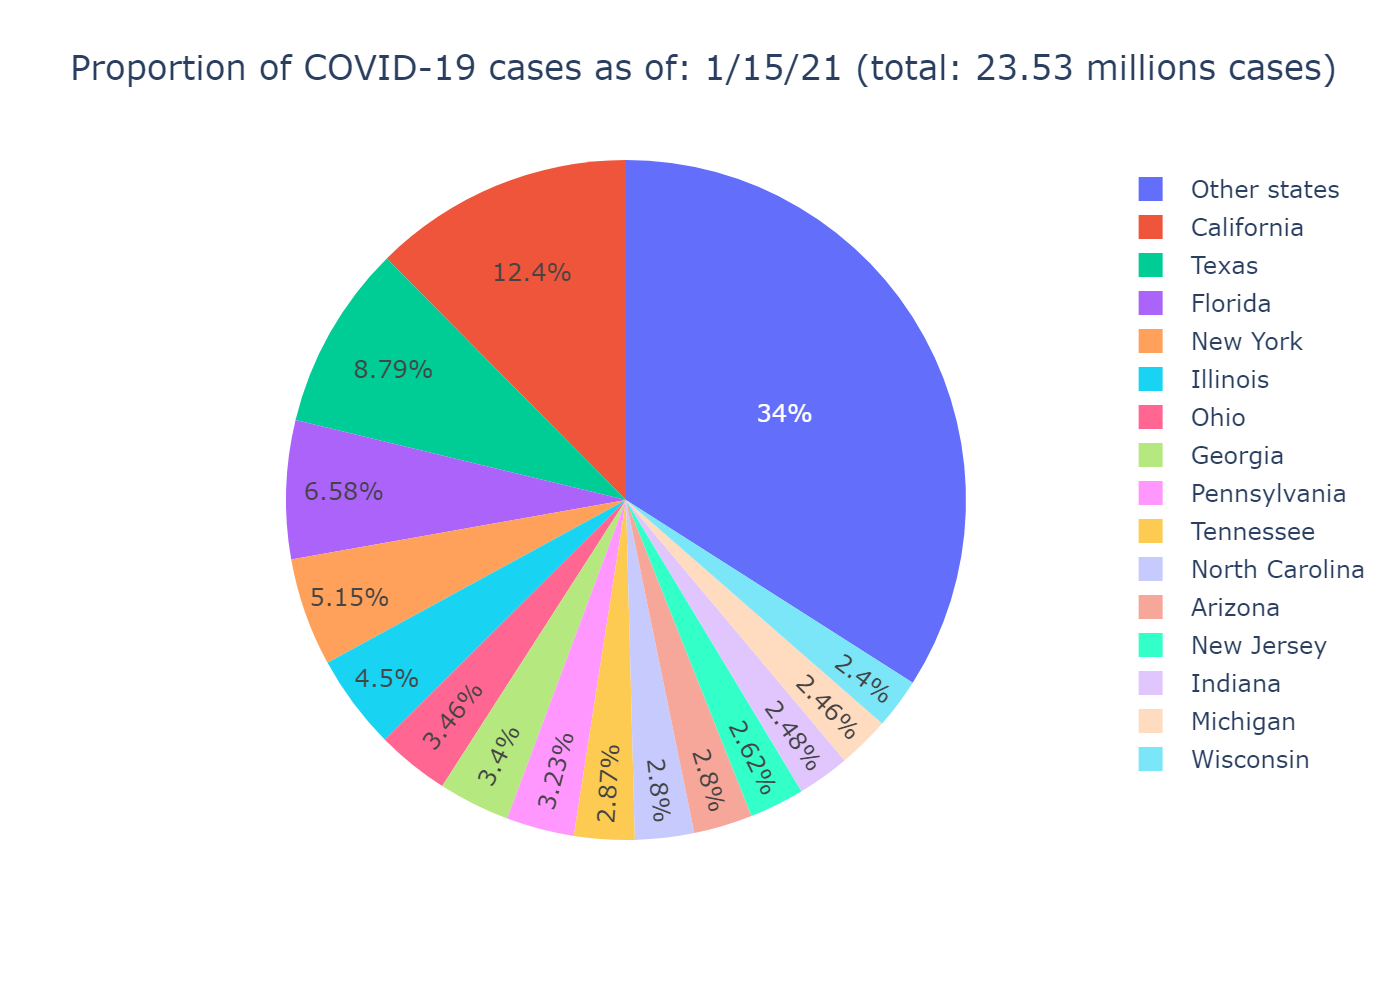

In [6]:
# Select top-15 states and aggregate all other countries
date_string = feature_column[2:]
total_case = round(US_state_case[date_string[-1]].sum() / 1000000, 2)
top_state = US_state_case.nlargest(15, date_string[-1])
state_collapse_bottom = US_state_case.copy()
state_collapse_bottom.loc[state_collapse_bottom[date_string[-1]] < top_state[date_string[-1]].min(),
                            'Province_State'] = 'Other states'


# Pie chart
fig = px.pie(state_collapse_bottom, values=date_string[-1], names='Province_State',
             title='Proportion of COVID-19 cases as of: ' + date_string[-1] + " (total: " + str(total_case) + " millions cases)")

margin_size = 80
fig.update_layout(margin=dict(l=margin_size, r=margin_size, t=margin_size, b=margin_size))

# Interactive plot
# fig.show()

# Static plot (to show the figures on Github, I have to convert to static image)
# For interactive plot, use the interactive plot above
Image(pio.to_image(fig, format='png', scale=2))

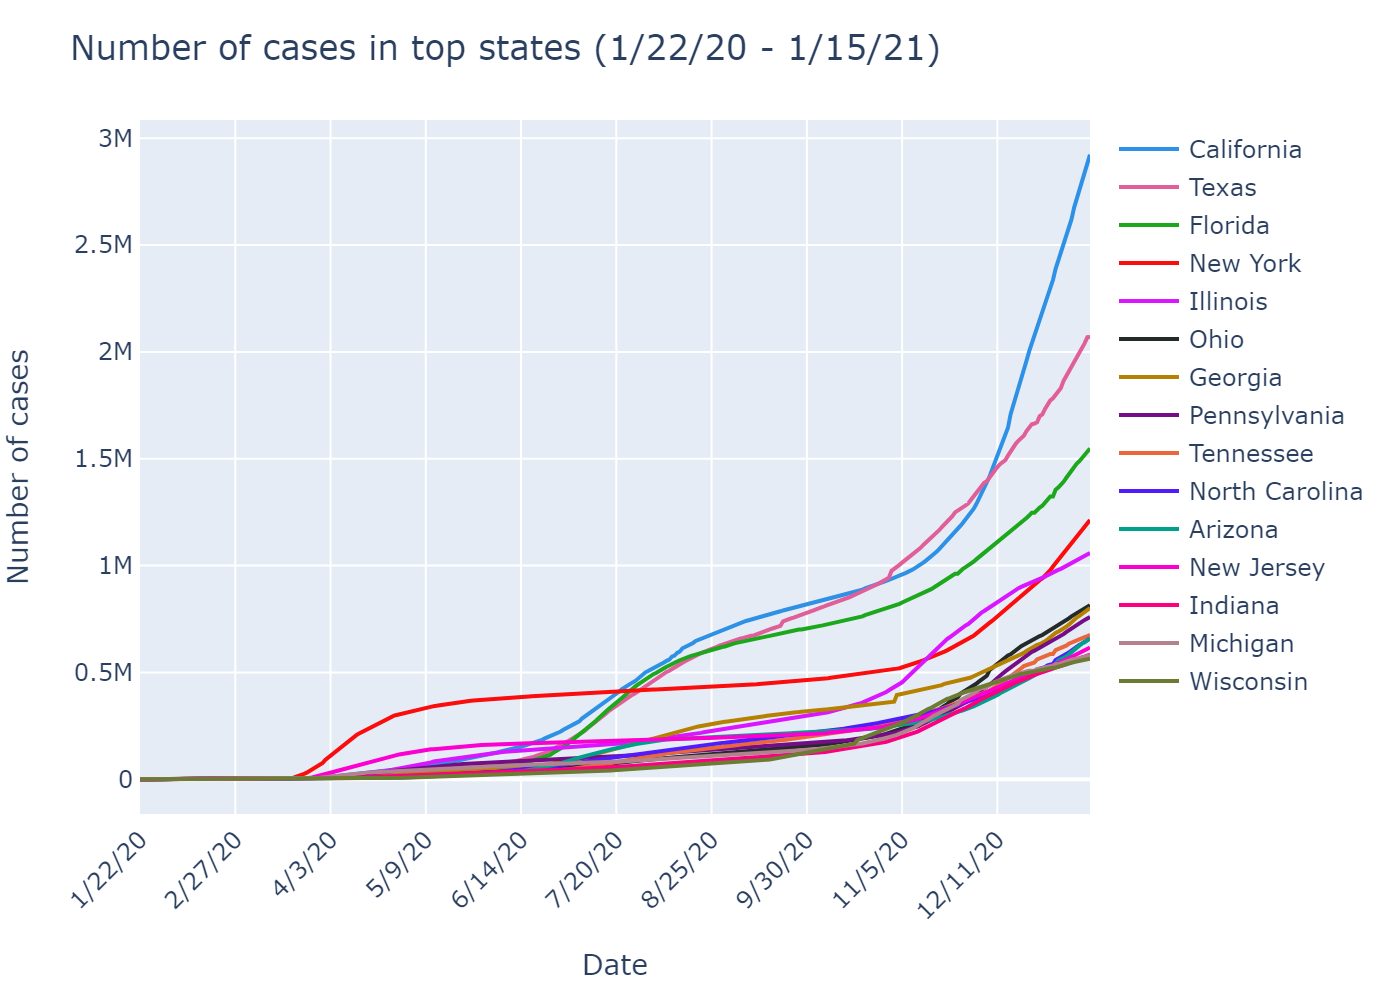

In [7]:
# Now let's look at the number of case across time
name_top_state = top_state['Province_State']
matrix_num_case = top_state.drop(columns=['Code', 'Province_State', 'Lat', 'Long_']).to_numpy()

# Plot the number of cases
fig = go.Figure()
color_values = plotly.colors.qualitative.Dark24
for index, country in enumerate(name_top_state):
    fig.add_trace(go.Scatter(x=date_string, y=matrix_num_case[index, :], name=country,
                             line=dict(color=color_values[index])))
    
margin_size = 60
fig.update_layout(title='Number of cases in top states (' + date_string[0] + ' - ' + date_string[-1] + ')',
                   xaxis_title='Date',
                   yaxis_title='Number of cases',
                 margin=dict(l=margin_size, r=margin_size, t=margin_size, b=margin_size), height=500)
fig.update_xaxes(tickangle=-45, nticks=10)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

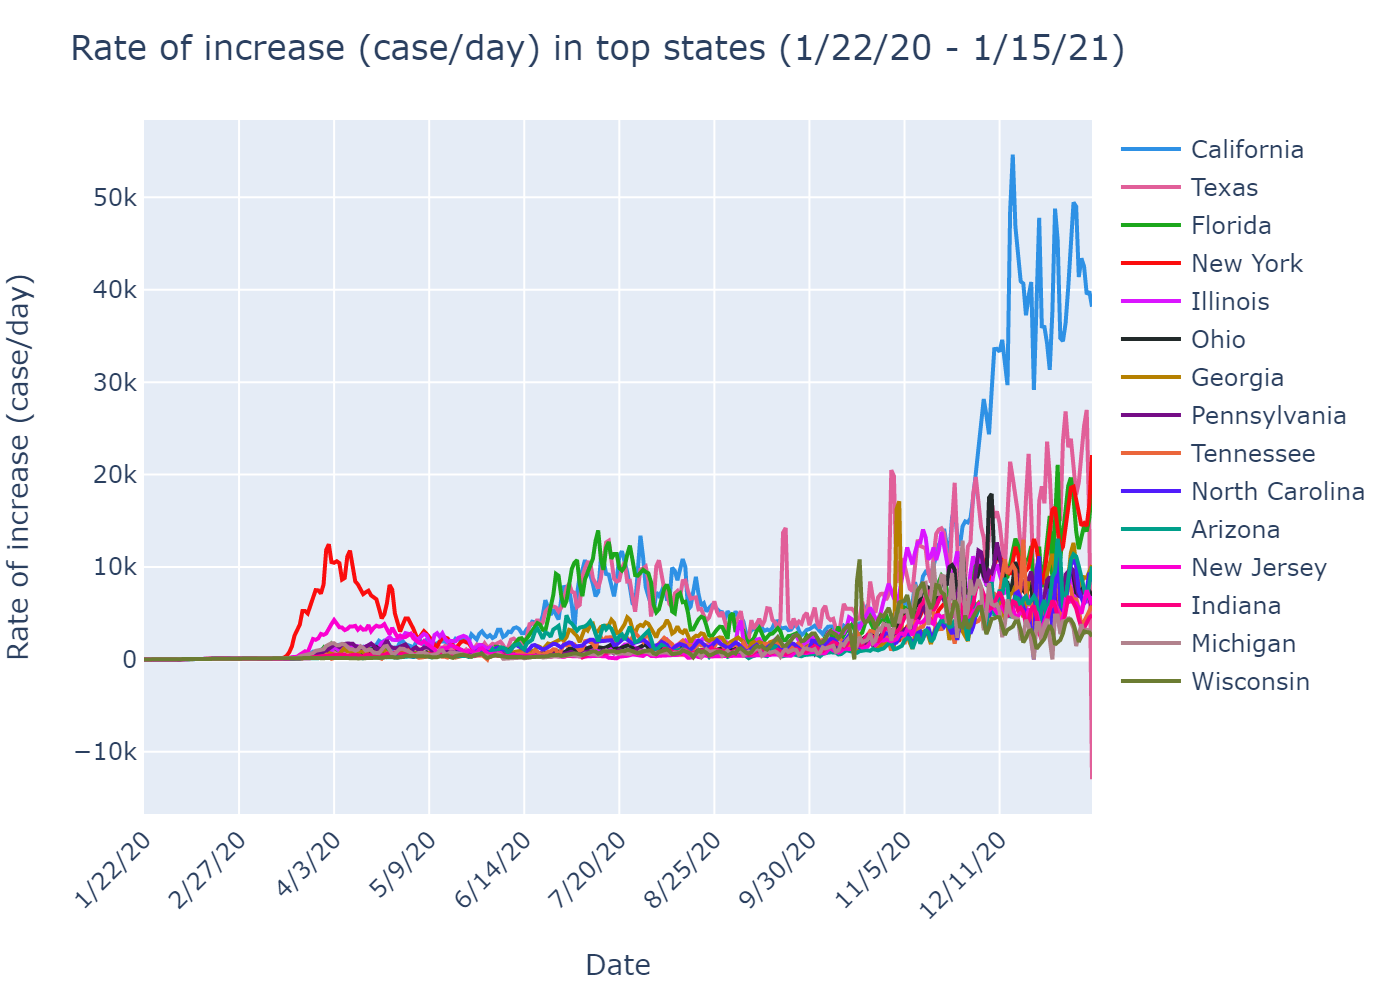

In [8]:
# Now let's look at the rate of increase
name_top_state = top_state['Province_State']
matrix_num_case_gradient = np.gradient(matrix_num_case, axis=1, edge_order =2)

# Plot the number of cases
fig = go.Figure()
color_values = plotly.colors.qualitative.Dark24
for index, country in enumerate(name_top_state):
    fig.add_trace(go.Scatter(x=date_string, y=matrix_num_case_gradient[index, :], name=country,
                             line=dict(color=color_values[index])))
    
margin_size = 60
fig.update_layout(title='Rate of increase (case/day) in top states (' + date_string[0] + ' - ' + date_string[-1] + ')',
                   xaxis_title='Date',
                   yaxis_title='Rate of increase (case/day)',
                 margin=dict(l=margin_size, r=margin_size, t=margin_size, b=margin_size), height=500)
fig.update_xaxes(tickangle=-45, nticks=10)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

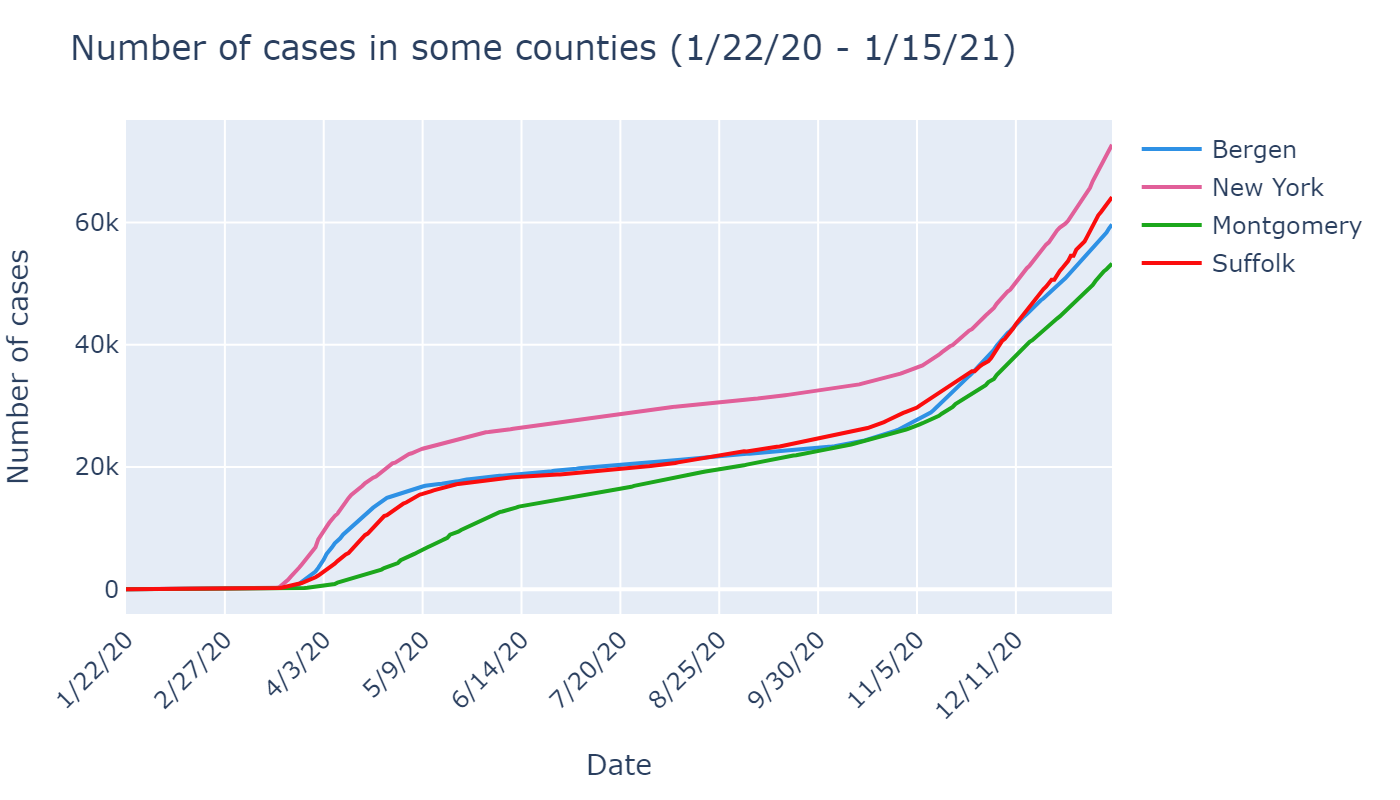

In [9]:
# Look at some cities I'm interested in
county_interest = US_case[US_case.County.isin(['New York', 'Bergen']) 
                          & US_case.Province_State.isin(['New York', 'New Jersey'])]
county_interest = county_interest.append(US_case[US_case.County.isin(['Montgomery']) & US_case.Province_State.isin(['Maryland'])])
county_interest = county_interest.append(US_case[US_case.County.isin(['Suffolk']) & US_case.Province_State.isin(['Massachusetts'])])
county_interest_name = county_interest['County']

# Now let's look at the number of case across time
matrix_num_case = county_interest.drop(columns=['FIPS', 'County', 'Province_State', 'Lat', 'Long_']).to_numpy()

# Plot the number of cases
fig = go.Figure()
color_values = plotly.colors.qualitative.Dark24
for index, country in enumerate(county_interest_name):
    fig.add_trace(go.Scatter(x=date_string, y=matrix_num_case[index, :], name=country,
                             line=dict(color=color_values[index])))
    
margin_size = 60
fig.update_layout(title='Number of cases in some counties (' + date_string[0] + ' - ' + date_string[-1] + ')',
                   xaxis_title='Date',
                   yaxis_title='Number of cases',
                 margin=dict(l=margin_size, r=margin_size, t=margin_size, b=margin_size), height=400)
fig.update_xaxes(tickangle=-45, nticks=10)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

## Look at bottom-15 states with the least number of cases

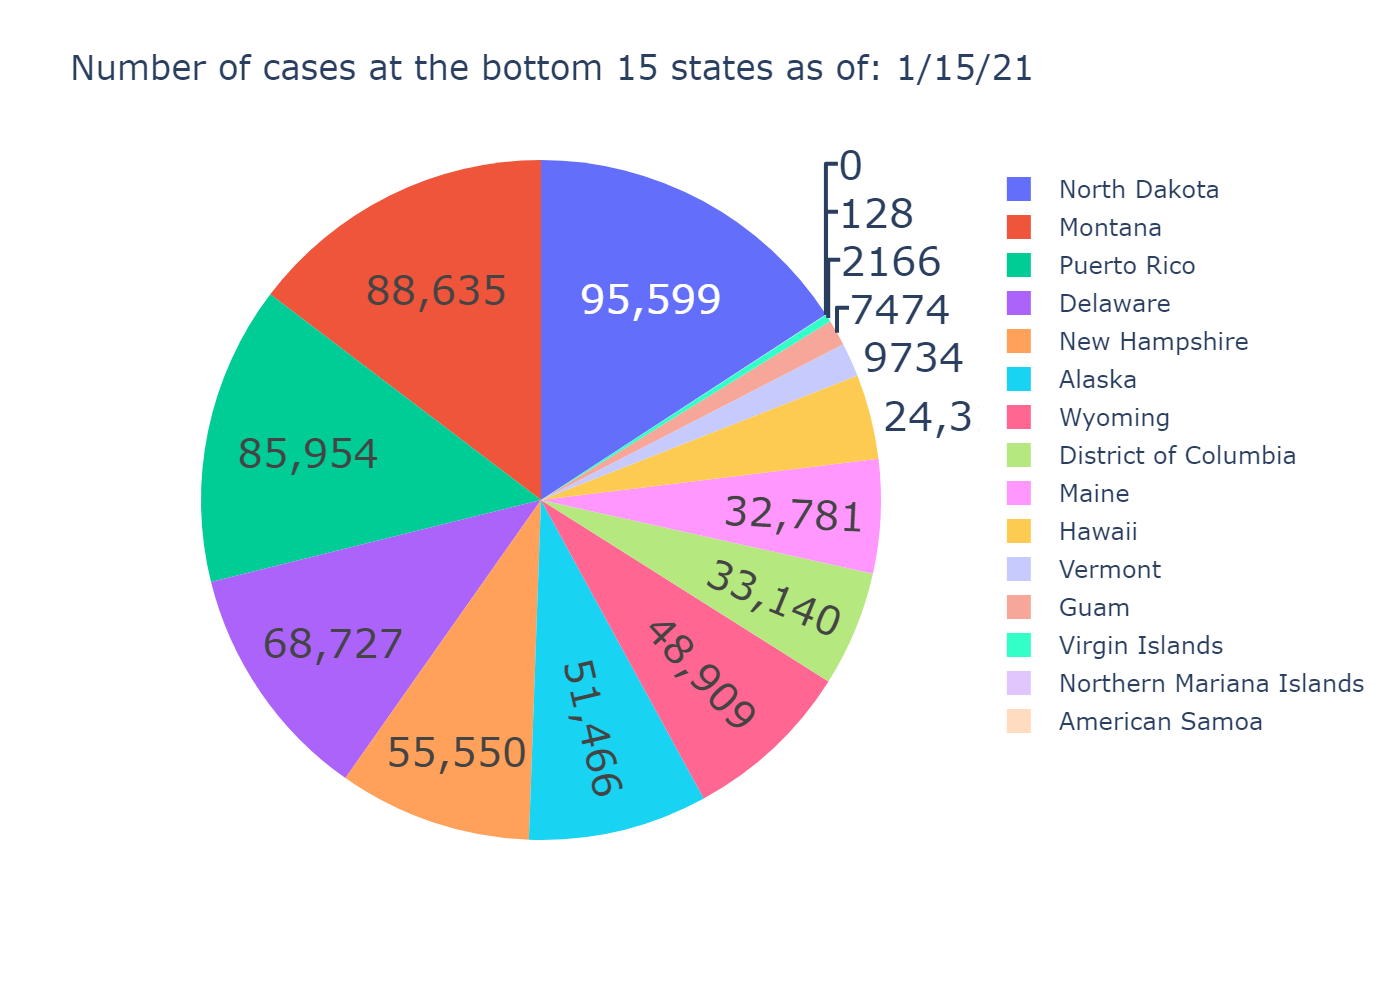

In [10]:
# Display the states with the least number of cases
bottom_state = US_state_case.nsmallest(15, date_string[-1])

fig = go.Figure(data=[go.Pie(labels=bottom_state['Province_State'],
                             values=bottom_state[date_string[-1]])])

margin_size = 80
fig.update_traces(hoverinfo='label+value', textinfo='value', textfont_size=20)
fig.update_layout(margin=dict(l=margin_size-20, r=margin_size-20, t=margin_size, b=margin_size),
                 title_text='Number of cases at the bottom 15 states as of: ' + date_string[-1])

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

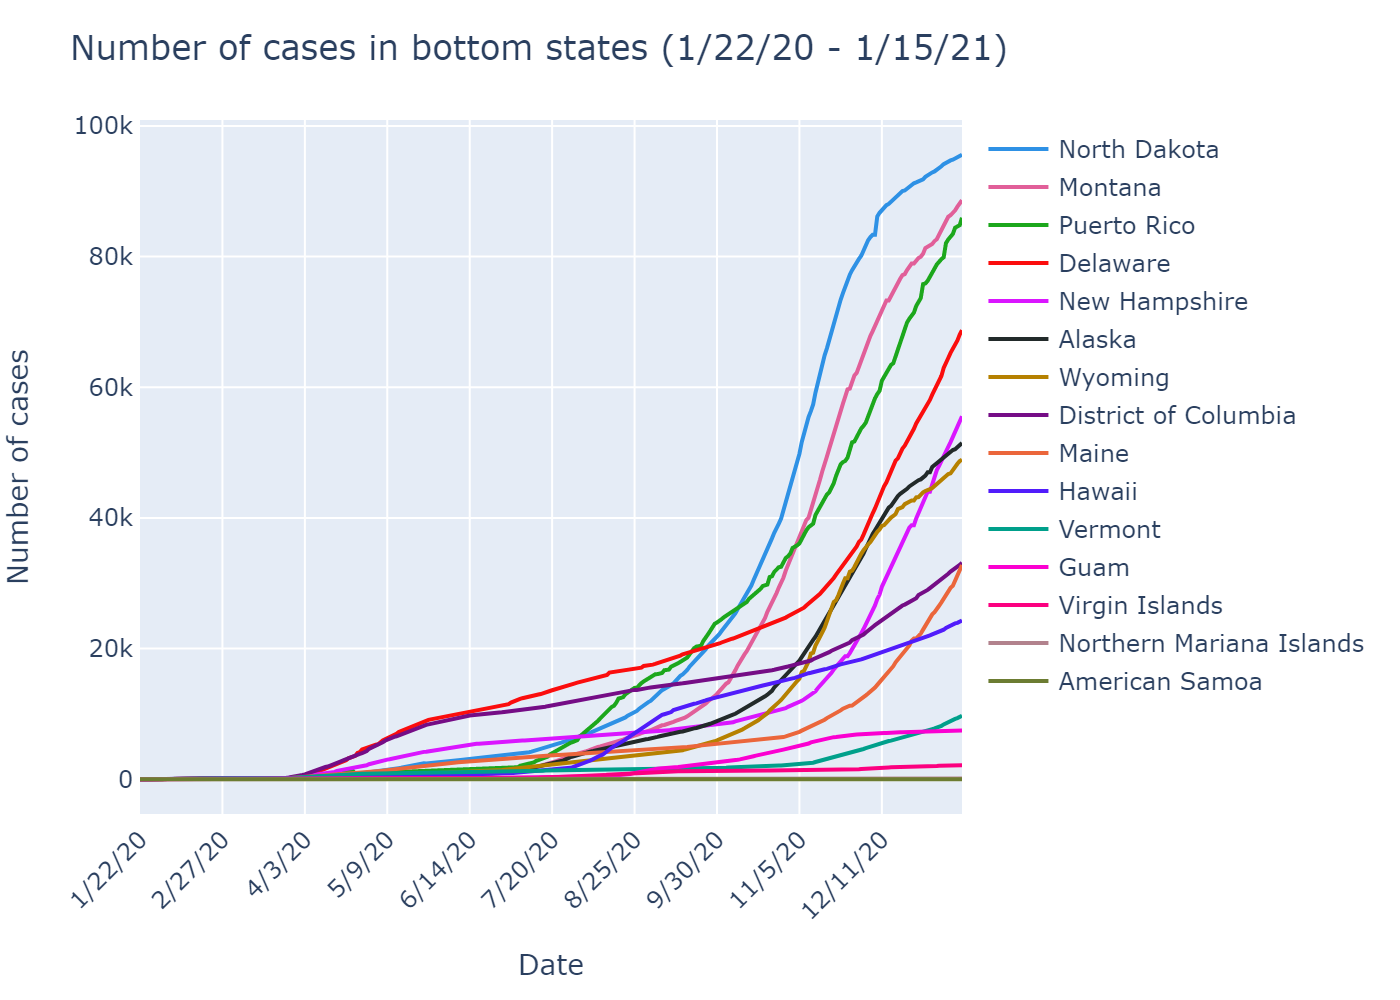

In [11]:
# Now let's look at the number of case across time
bottom_state.sort_values(by=[date_string[-1]], ascending=False, inplace=True)
name_bottom_state = bottom_state['Province_State']
matrix_num_case = bottom_state.drop(columns=['Code', 'Province_State', 'Lat', 'Long_']).to_numpy()

# Plot the number of cases
fig = go.Figure()
color_values = plotly.colors.qualitative.Dark24
for index, country in enumerate(name_bottom_state):
    fig.add_trace(go.Scatter(x=date_string, y=matrix_num_case[index, :], name=country,
                             line=dict(color=color_values[index])))
    
margin_size = 60
fig.update_layout(title='Number of cases in bottom states (' + date_string[0] + ' - ' + date_string[-1] + ')',
                   xaxis_title='Date',
                   yaxis_title='Number of cases',
                 margin=dict(l=margin_size, r=margin_size, t=margin_size, b=margin_size), height=500)
fig.update_xaxes(tickangle=-45, nticks=10)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

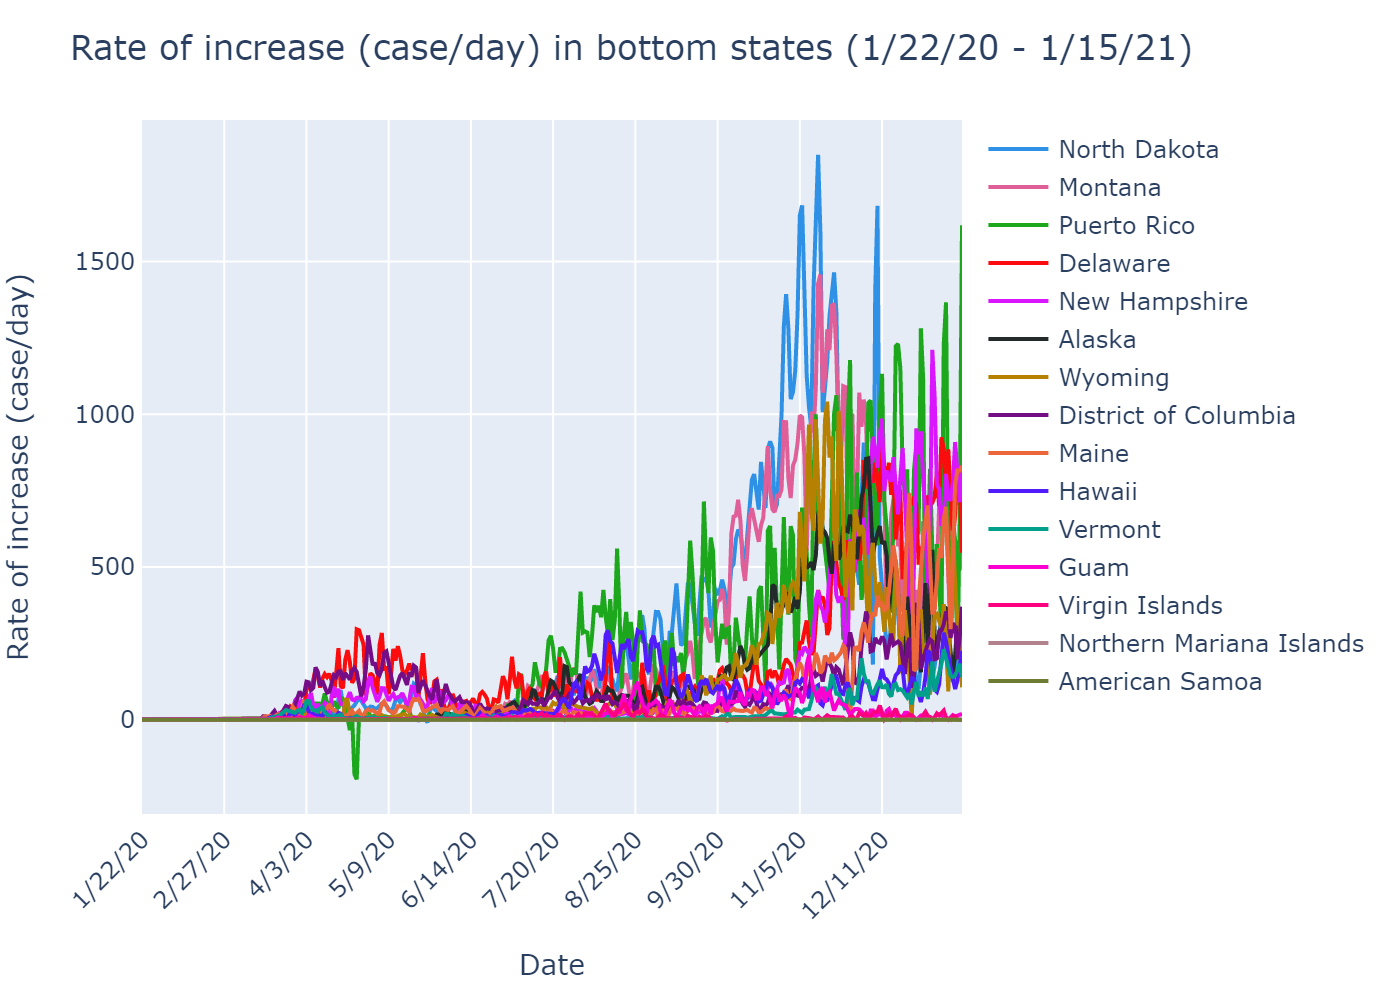

In [12]:
# Now let's look at the rate of increase
matrix_num_case_gradient = np.gradient(matrix_num_case, axis=1, edge_order =2)

# Plot the number of cases
fig = go.Figure()
color_values = plotly.colors.qualitative.Dark24
for index, country in enumerate(name_bottom_state):
    fig.add_trace(go.Scatter(x=date_string, y=matrix_num_case_gradient[index, :], name=country,
                             line=dict(color=color_values[index])))
    
margin_size = 60
fig.update_layout(title='Rate of increase (case/day) in bottom states (' + date_string[0] + ' - ' + date_string[-1] + ')',
                   xaxis_title='Date',
                   yaxis_title='Rate of increase (case/day)',
                 margin=dict(l=margin_size, r=margin_size, t=margin_size, b=margin_size), height=500)
fig.update_xaxes(tickangle=-45, nticks=10)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

## See the cases on map

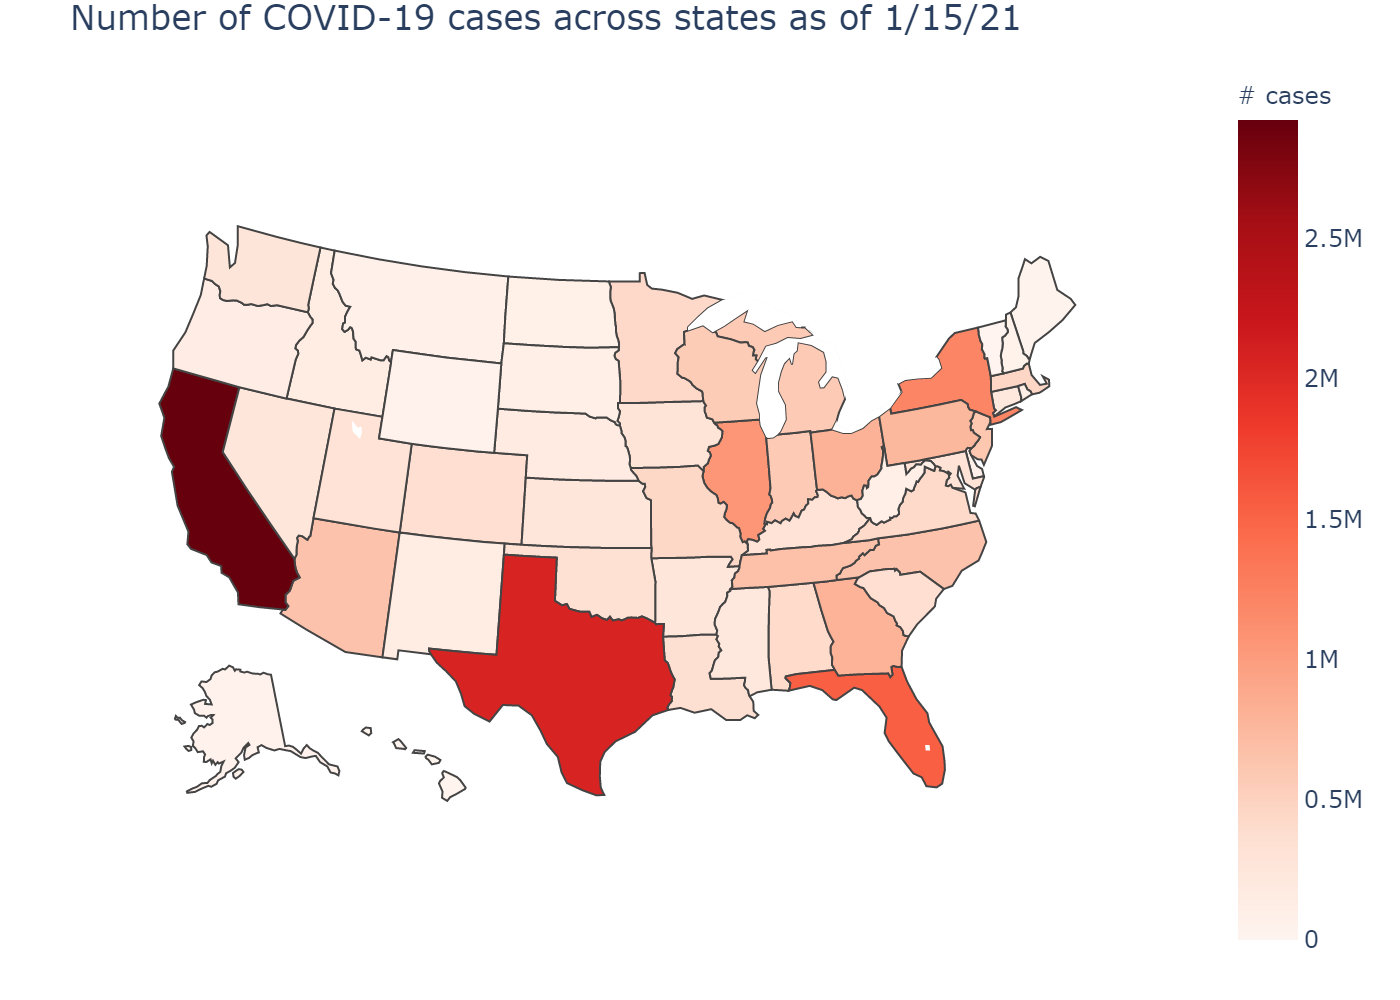

In [13]:
# Plot all states
fig = go.Figure(data=go.Choropleth(
    locations=US_state_case["Code"], # state names
    locationmode = "USA-states", # set the mode to country name
    z = US_state_case[date_string[-1]].astype(float), # Data to be color-coded
    colorscale = 'Reds',
    colorbar_title = "# cases",
    text=US_state_case["Province_State"]    
))

fig.update_layout(
    title_text = 'Number of COVID-19 cases across states as of ' + date_string[-1],
    margin=dict(l=20, r=20, t=30, b=20),
    geo_scope='usa', # limite map scope to USA
)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

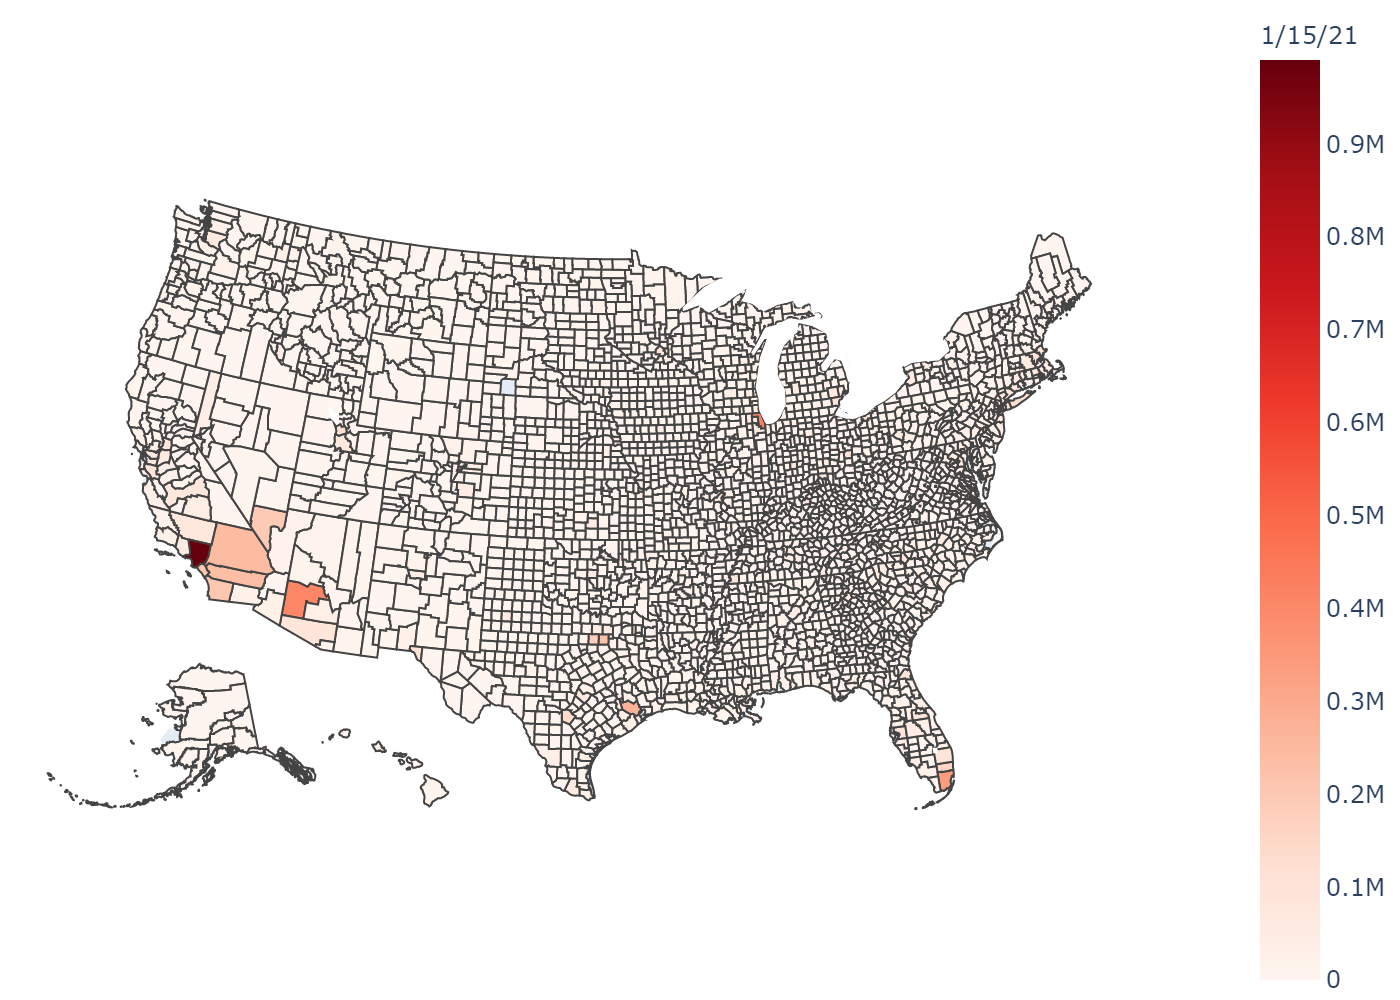

In [14]:
# Convert FIPS to appropriate format For plotting
fips_mat = US_case.loc[US_case.FIPS.notnull(), 'FIPS'].values
fips_mat = list(fips_mat.astype('int32').astype(str))
for index, fips in enumerate(fips_mat):
    if len(fips) == 2:
        fips_mat[index] = '000' + fips_mat[index]
    elif len(fips) == 3:
        fips_mat[index] = '00' + fips_mat[index]
    elif len(fips) == 4:
        fips_mat[index] = '0' + fips_mat[index]
        
US_case.loc[US_case.FIPS.notnull(), 'FIPS'] = fips_mat

# Plot the county map      
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
    
# Map without New York city
US_case_dropNY = US_case[US_case['County'] != 'New York']
fig = px.choropleth(US_case_dropNY, geojson=counties, locations='FIPS', color=date_string[-1],
                    color_continuous_scale="Reds", hover_name='County', scope="usa")

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

### It seems like most cases are localized to small regions (esp. the busy areas).

# Explore and analyze deaths

## Clean up the data

In [15]:
# Drop unimportant columns
US_death.drop(columns=['UID', 'iso2', 'iso3','code3', 'Combined_Key', 'Country_Region'], inplace=True)

# Drop states associated with cruise ships
US_death.drop(US_death.index[US_death.Province_State.isin(['Diamond Princess', 'Grand Princess'])], inplace=True)

# Rename county column
US_death.rename(columns={'Admin2': 'County'}, inplace=True)

In [16]:
US_death.iloc[:5, :10]

FIPS   County Province_State        Lat      Long_  Population  1/22/20  \
0  1001.0  Autauga        Alabama  32.539527 -86.644082       55869        0   
1  1003.0  Baldwin        Alabama  30.727750 -87.722071      223234        0   
2  1005.0  Barbour        Alabama  31.868263 -85.387129       24686        0   
3  1007.0     Bibb        Alabama  32.996421 -87.125115       22394        0   
4  1009.0   Blount        Alabama  33.982109 -86.567906       57826        0   

   1/23/20  1/24/20  1/25/20  
0        0        0        0  
1        0        0        0  
2        0        0        0  
3        0        0        0  
4        0        0        0

In [17]:
# Collapse across states
# We want to take the mean across 'Lat' and 'Long_' columns
# and sum across the case and 'Population' columns.
dict_transform = {}
feature_column = US_death.keys()[3:]
for column in feature_column:
    if column in ['Lat', 'Long_']:
        dict_transform[column] = 'mean'
    elif column == 'Population':
        dict_transform[column] = 'sum'
    else:
        dict_transform[column] = 'sum'
        
US_death_state = US_death.groupby('Province_State').agg(dict_transform).reset_index()

In [18]:
# Merge the state code table (for plotting chloropeth map)
US_death_state = US_state_abbreviation.merge(US_death_state, left_on='State', right_on='Province_State', how='outer')
US_death_state.drop(columns=['State'], inplace=True)

In [19]:
US_death_state.head(2)

Code Province_State        Lat       Long_  Population  1/22/20  1/23/20  \
0   AL        Alabama  31.931113  -84.196785   4903185.0      0.0      0.0   
1   AK         Alaska  56.360573 -138.486138    731545.0      0.0      0.0   

   1/24/20  1/25/20  1/26/20  ...  1/6/21  1/7/21  1/8/21  1/9/21  1/10/21  \
0      0.0      0.0      0.0  ...  4994.0  5080.0  5191.0  5299.0   5334.0   
1      0.0      0.0      0.0  ...   220.0   223.0   223.0   224.0    224.0   

   1/11/21  1/12/21  1/13/21  1/14/21  1/15/21  
0   5347.0   5573.0   5760.0   5945.0   6030.0  
1    224.0    225.0    226.0    228.0    229.0  

[2 rows x 365 columns]

## Look at top-15 states with the most number of deaths

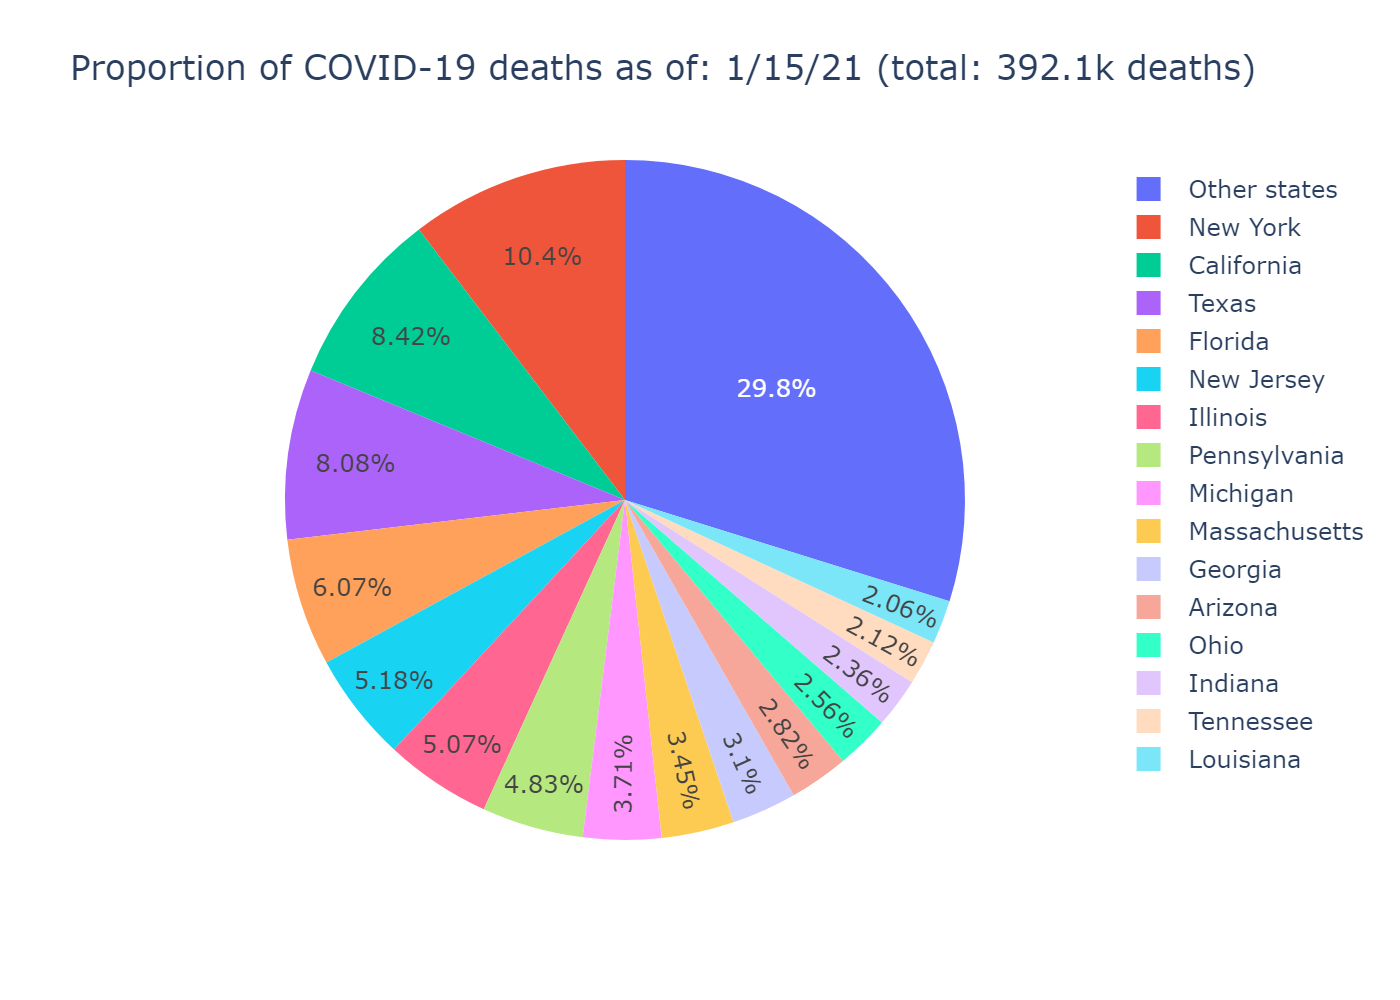

In [20]:
# Select top-15 states and aggregate all other countries
total_case = round(US_death_state[date_string[-1]].sum() / 1000, 1)
top_state = US_death_state.nlargest(15, date_string[-1])
state_collapse_bottom = US_death_state.copy()
state_collapse_bottom.loc[state_collapse_bottom[date_string[-1]] < top_state[date_string[-1]].min(),
                            'Province_State'] = 'Other states'


# Pie chart
fig = px.pie(state_collapse_bottom, values=date_string[-1], names='Province_State',
             title='Proportion of COVID-19 deaths as of: ' + date_string[-1] + " (total: " + str(total_case) + "k deaths)")

margin_size = 80
fig.update_layout(margin=dict(l=margin_size, r=margin_size, t=margin_size, b=margin_size))

# Interactive plot
# fig.show()

# Static plot (to show the figures on Github, I have to convert to static image)
# For interactive plot, use the interactive plot above
Image(pio.to_image(fig, format='png', scale=2))

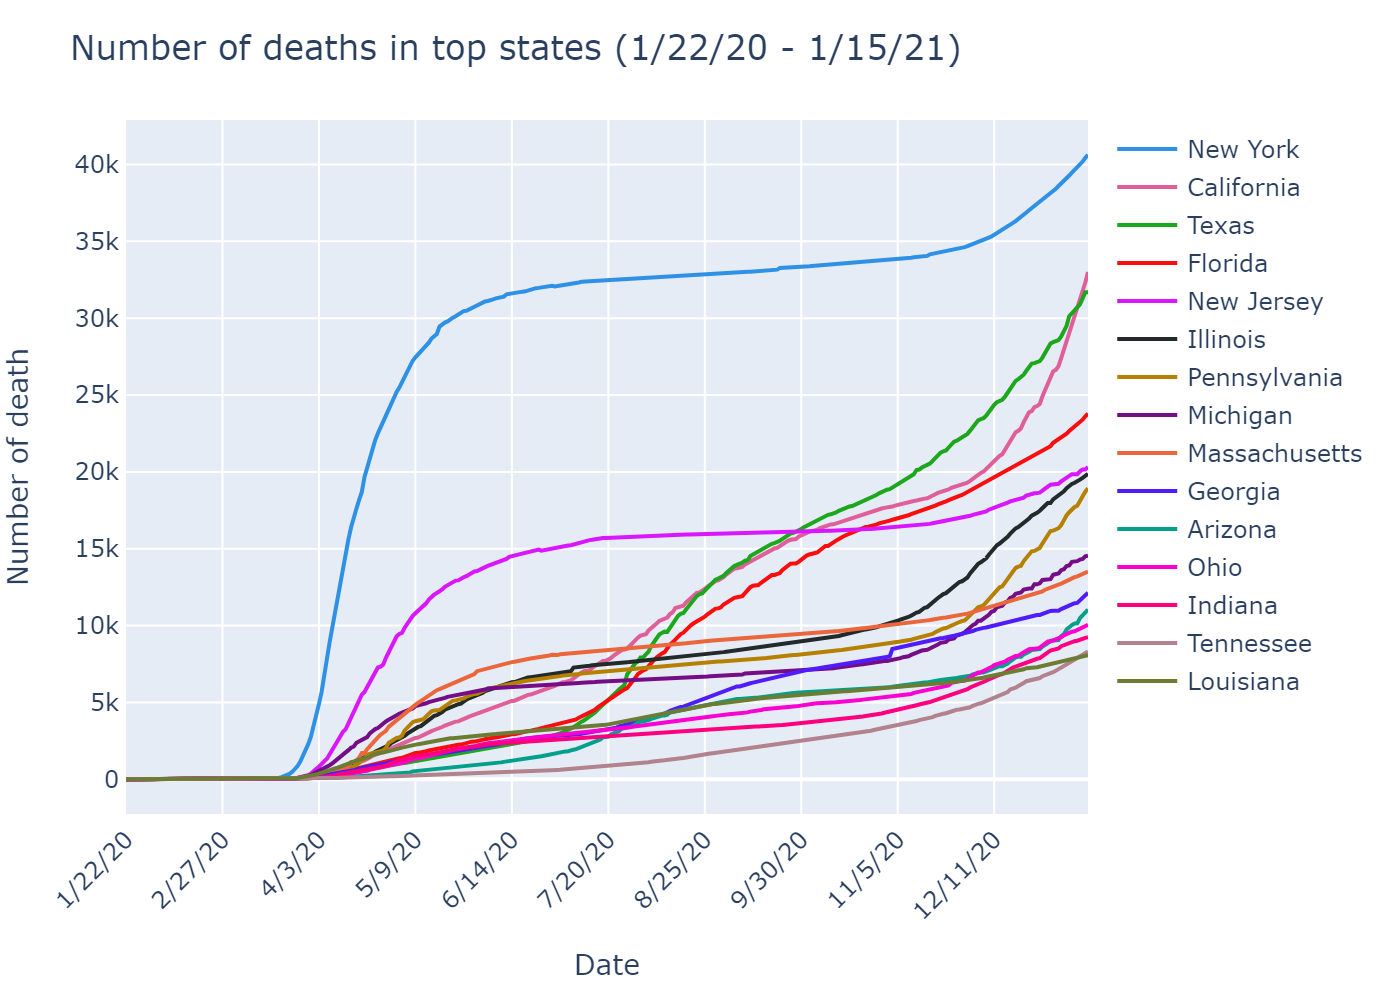

In [21]:
# Now let's look at the number of death across time
name_top_state = top_state['Province_State']
matrix_num_case = top_state.drop(columns=['Code', 'Province_State', 'Lat', 'Long_', 'Population']).to_numpy()

# Plot the number of cases
fig = go.Figure()
color_values = plotly.colors.qualitative.Dark24
for index, country in enumerate(name_top_state):
    fig.add_trace(go.Scatter(x=date_string, y=matrix_num_case[index, :], name=country,
                             line=dict(color=color_values[index])))
    
margin_size = 60
fig.update_layout(title='Number of deaths in top states (' + date_string[0] + ' - ' + date_string[-1] + ')',
                   xaxis_title='Date',
                   yaxis_title='Number of death',
                 margin=dict(l=margin_size, r=margin_size, t=margin_size, b=margin_size), height=500)
fig.update_xaxes(tickangle=-45, nticks=10)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

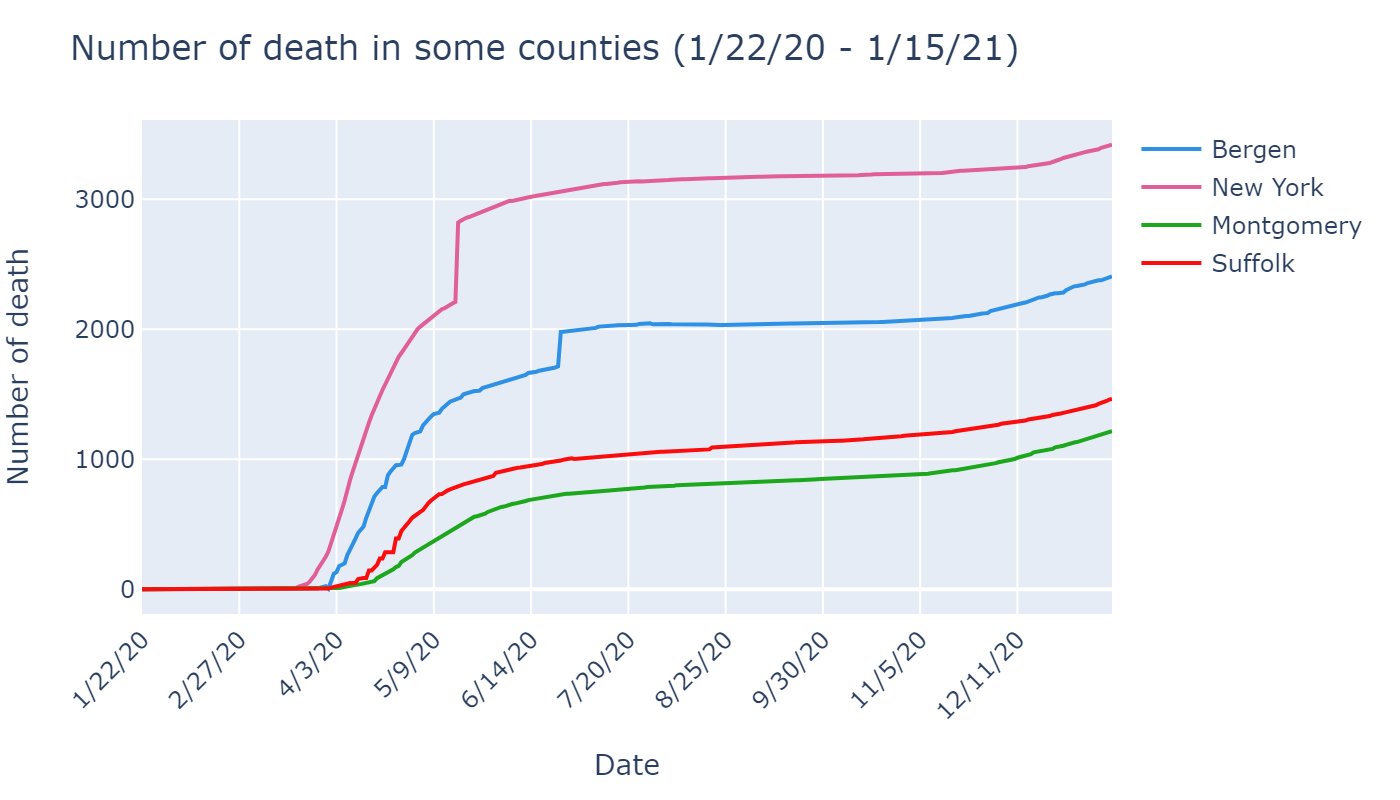

In [22]:
# Look at some cities I'm interested in
county_interest = US_death[US_death.County.isin(['New York', 'Bergen']) 
                          & US_death.Province_State.isin(['New York', 'New Jersey'])]
county_interest = county_interest.append(US_death[US_death.County.isin(['Montgomery']) & US_death.Province_State.isin(['Maryland'])])
county_interest = county_interest.append(US_death[US_death.County.isin(['Suffolk']) & US_death.Province_State.isin(['Massachusetts'])])

county_interest_name = county_interest['County']

# Now let's look at the number of case across time
matrix_num_case = county_interest.drop(columns=['FIPS', 'County', 'Province_State', 'Lat', 'Long_', 'Population']).to_numpy()

# Plot the number of cases
fig = go.Figure()
color_values = plotly.colors.qualitative.Dark24
for index, country in enumerate(county_interest_name):
    fig.add_trace(go.Scatter(x=date_string, y=matrix_num_case[index, :], name=country,
                             line=dict(color=color_values[index])))
    
margin_size = 60
fig.update_layout(title='Number of death in some counties (' + date_string[0] + ' - ' + date_string[-1] + ')',
                   xaxis_title='Date',
                   yaxis_title='Number of death',
                 margin=dict(l=margin_size, r=margin_size, t=margin_size, b=margin_size), height=400)
fig.update_xaxes(tickangle=-45, nticks=10)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

## Look at bottom-15 states with the least number of death

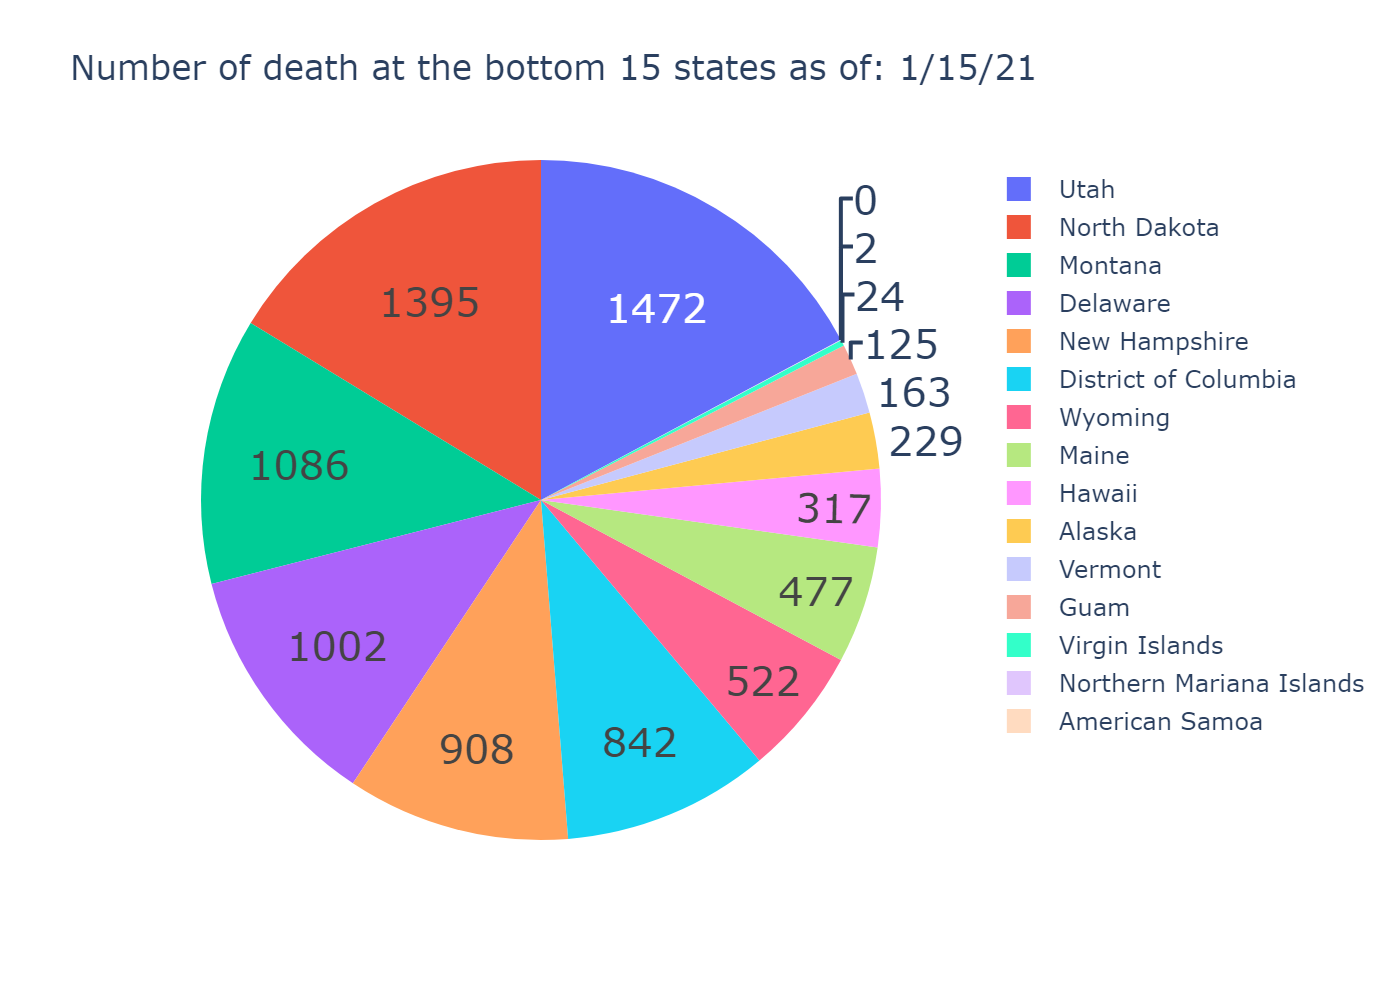

In [23]:
# Display the states with the least number of cases
bottom_state = US_death_state.nsmallest(15, date_string[-1])

fig = go.Figure(data=[go.Pie(labels=bottom_state['Province_State'],
                             values=bottom_state[date_string[-1]])])

margin_size = 80
fig.update_traces(hoverinfo='label+value', textinfo='value', textfont_size=20)
fig.update_layout(margin=dict(l=margin_size-20, r=margin_size-20, t=margin_size, b=margin_size),
                 title_text='Number of death at the bottom 15 states as of: ' + date_string[-1])

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

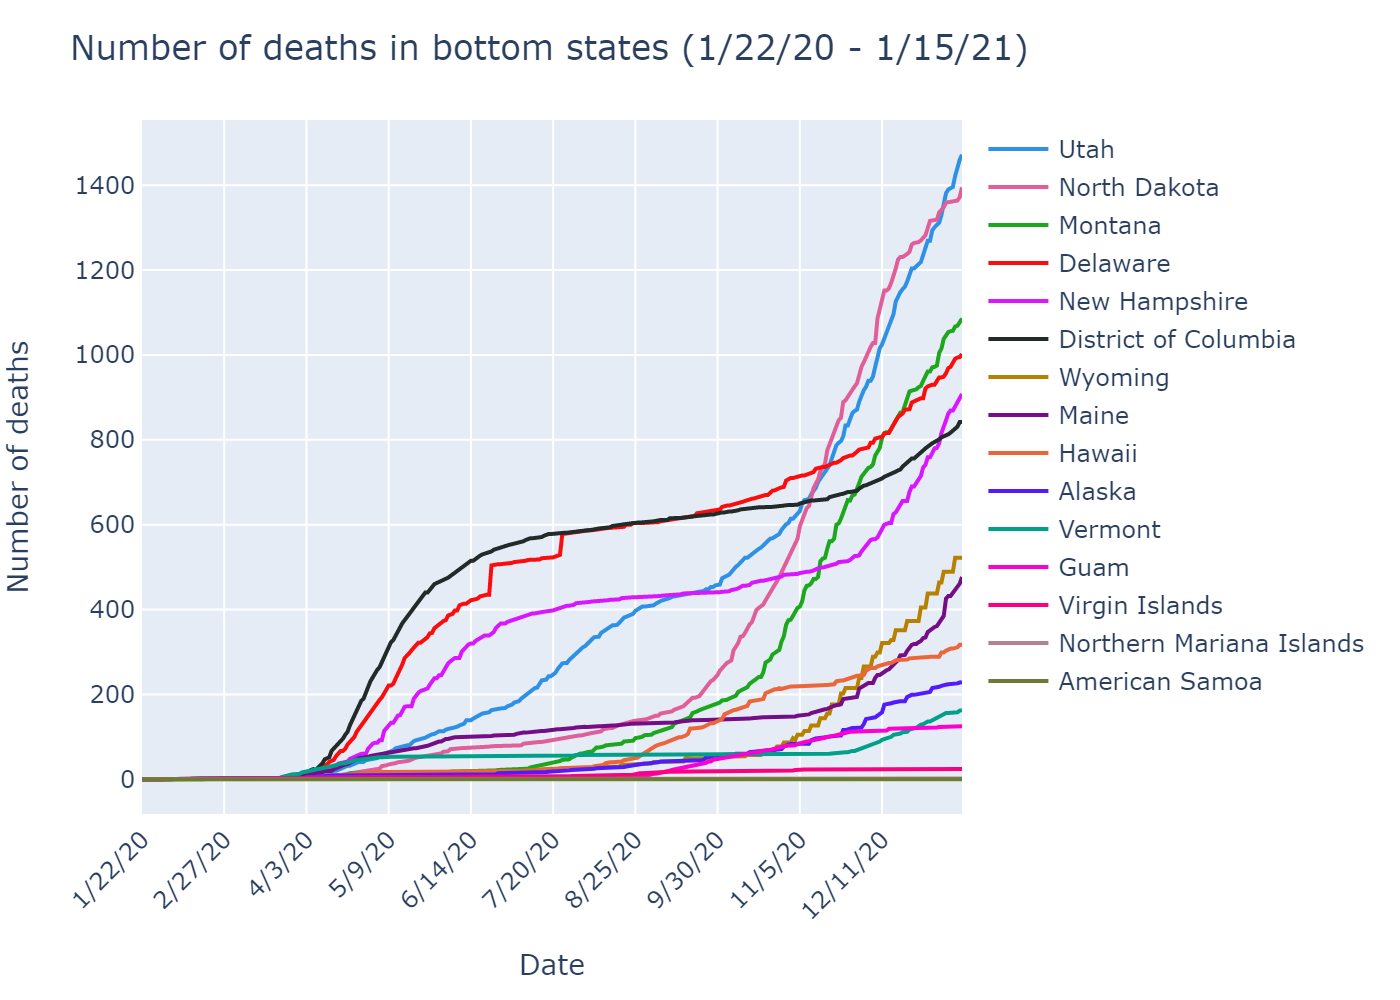

In [24]:
# Now let's look at the number of case across time
bottom_state.sort_values(by=[date_string[-1]], ascending=False, inplace=True)
name_bottom_state = bottom_state['Province_State']
matrix_num_case = bottom_state.drop(columns=['Code', 'Province_State', 'Lat', 'Long_', 'Population']).to_numpy()

# Plot the number of cases
fig = go.Figure()
color_values = plotly.colors.qualitative.Dark24
for index, country in enumerate(name_bottom_state):
    fig.add_trace(go.Scatter(x=date_string, y=matrix_num_case[index, :], name=country,
                             line=dict(color=color_values[index])))
    
margin_size = 60
fig.update_layout(title='Number of deaths in bottom states (' + date_string[0] + ' - ' + date_string[-1] + ')',
                   xaxis_title='Date',
                   yaxis_title='Number of deaths',
                 margin=dict(l=margin_size, r=margin_size, t=margin_size, b=margin_size), height=500)
fig.update_xaxes(tickangle=-45, nticks=10)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

## Make new table at state level, include # case, % case, population, death, death rate 

In [25]:
# Make new table from existing data
US_state = US_death_state.loc[:, 'Code':'Population']
US_state['Death'] = US_death_state.iloc[:, -1]
US_state['Num_case'] = US_state_case.iloc[:, -1]
US_state['Percent_case'] = 100 * US_state['Num_case'] / US_state['Population']
US_state['Death_rate'] = 100 * US_state['Death'] / US_state['Num_case']

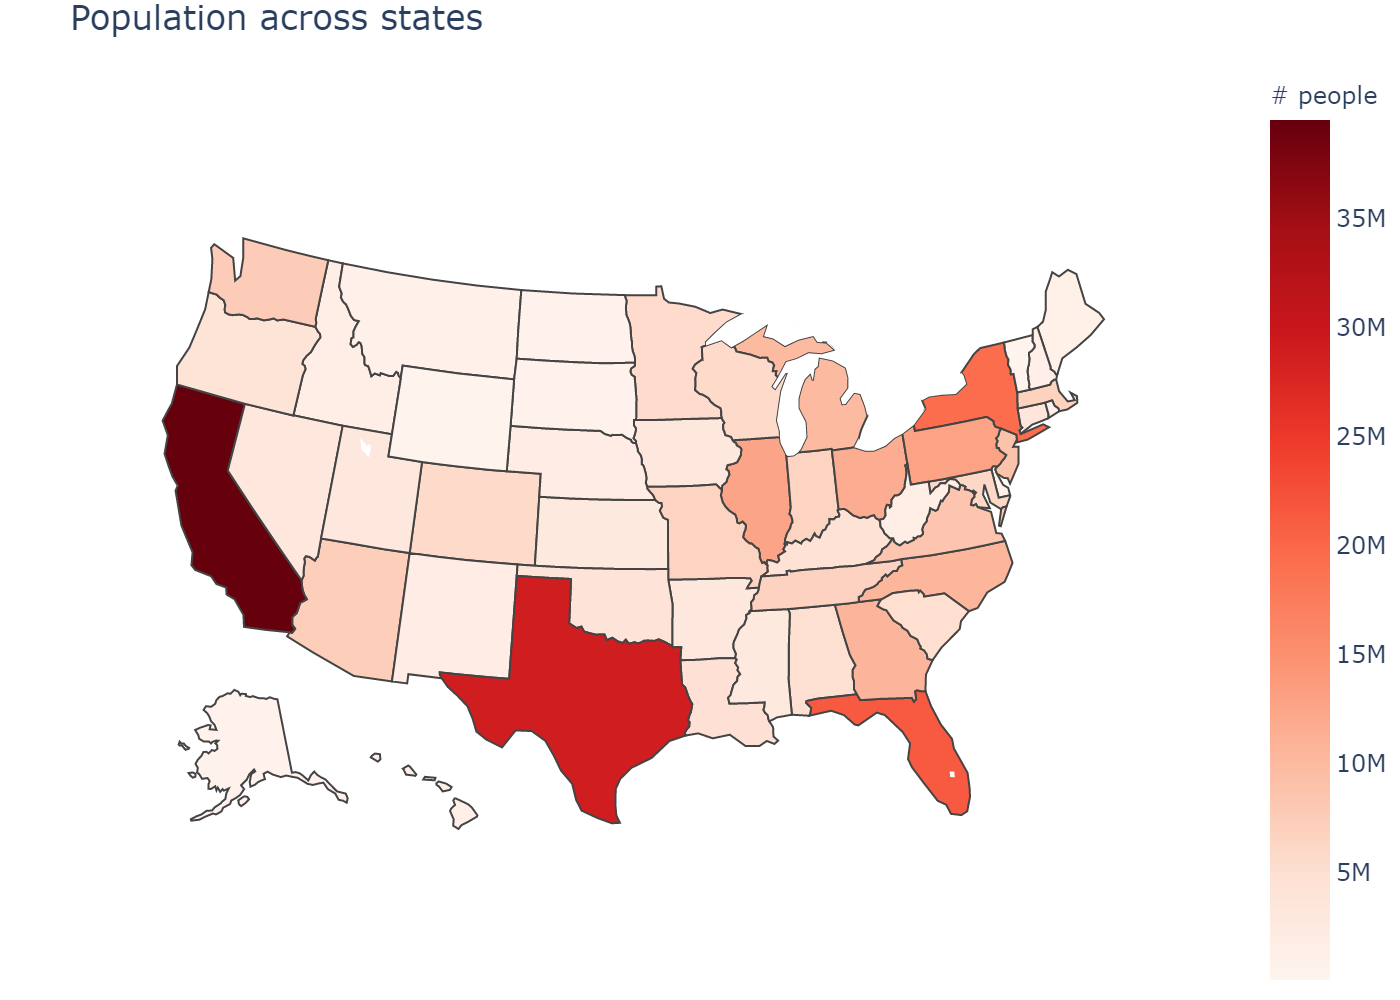

In [26]:
# Check population map
fig = go.Figure(data=go.Choropleth(
    locations=US_state["Code"], # state names
    locationmode = "USA-states", # set the mode to country name
    z = US_state['Population'].astype(float), # Data to be color-coded
    colorscale = 'Reds',
    colorbar_title = "# people",
    text=US_state["Province_State"]    
))

fig.update_layout(
    title_text = 'Population across states',
    margin=dict(l=20, r=20, t=30, b=0),
    geo_scope='usa', # limite map scope to USA
)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

## See the number of deaths, death rate and percent of case on map

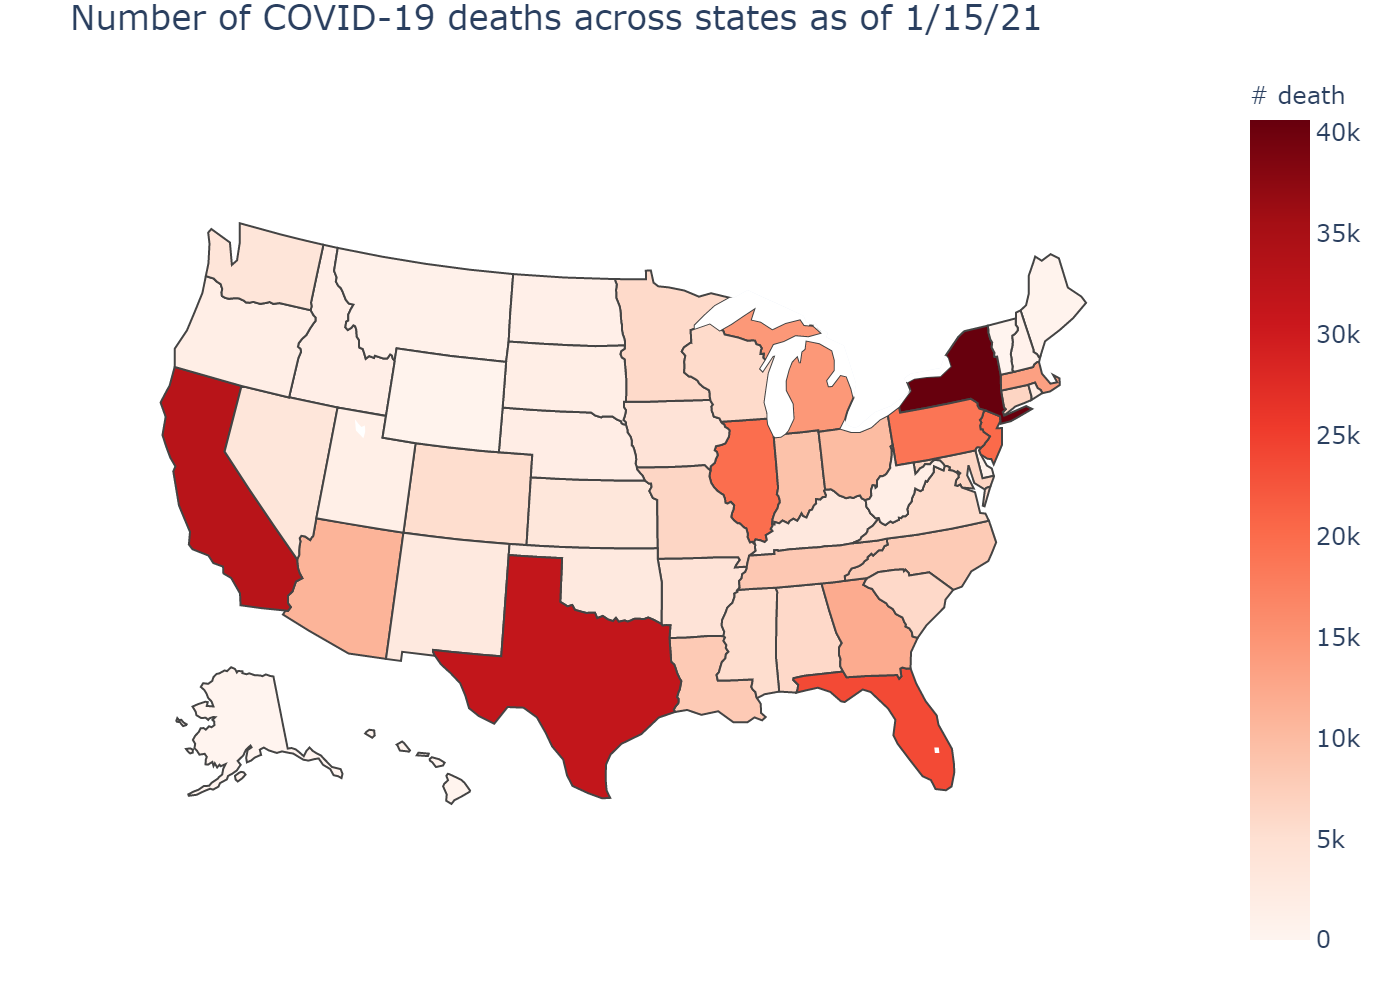

In [27]:
# Number of death
fig = go.Figure(data=go.Choropleth(
    locations=US_state["Code"], # state names
    locationmode = "USA-states", # set the mode to country name
    z = US_state['Death'].astype(float), # Data to be color-coded
    colorscale = 'Reds',
    colorbar_title = "# death",
    text=US_state["Province_State"]    
))

fig.update_layout(
    title_text = 'Number of COVID-19 deaths across states as of ' + date_string[-1],
    margin=dict(l=20, r=20, t=30, b=20),
    geo_scope='usa', # limite map scope to USA
)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

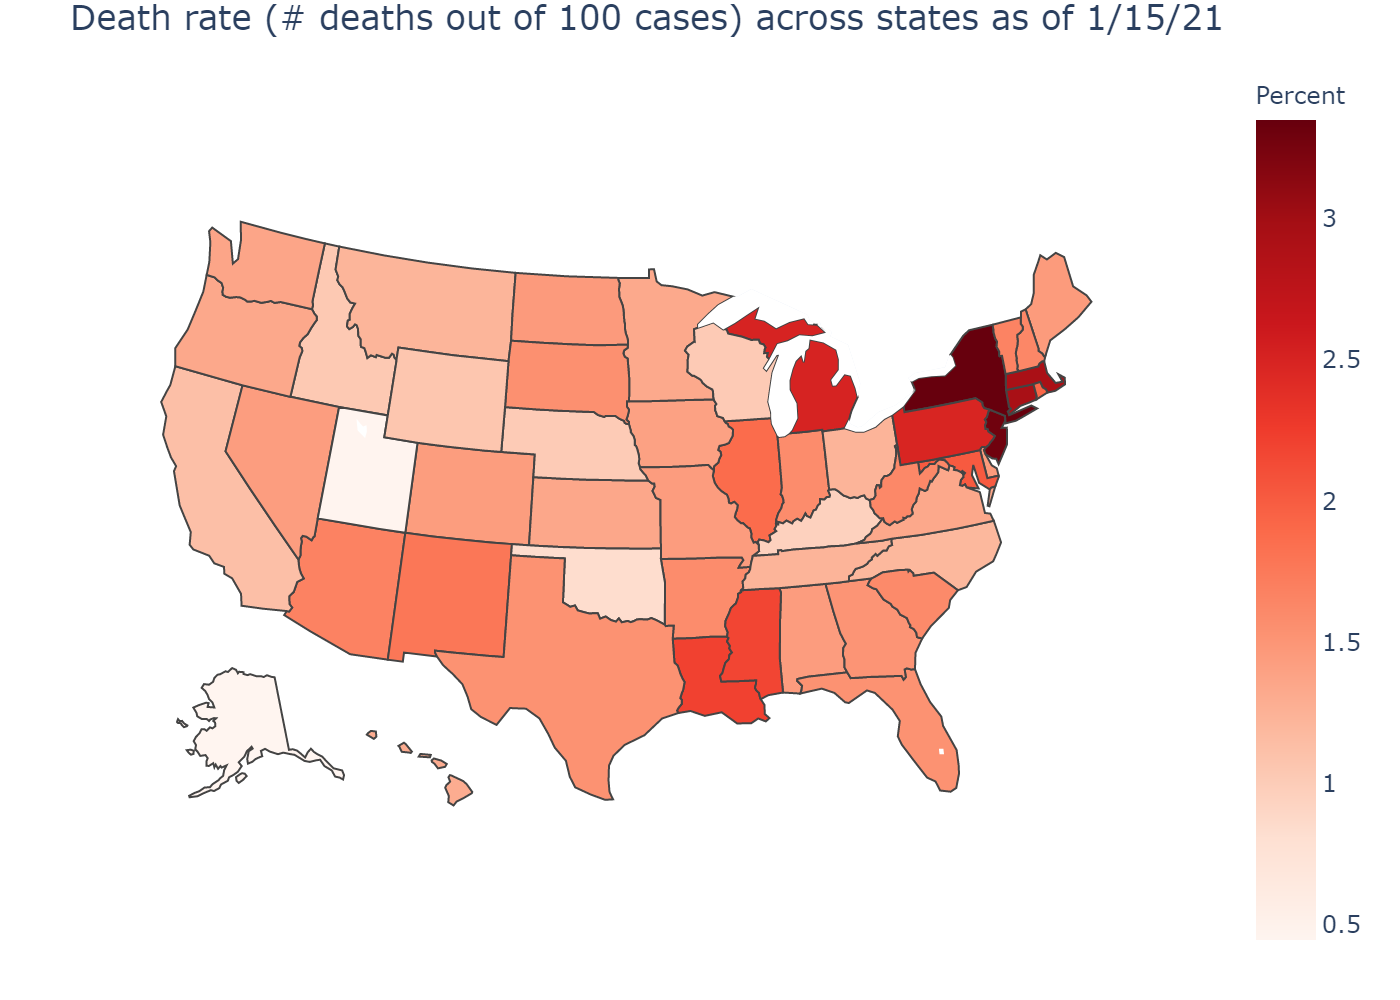

In [28]:
# Death rate
fig = go.Figure(data=go.Choropleth(
    locations=US_state["Code"], # state names
    locationmode = "USA-states", # set the mode to country name
    z = US_state['Death_rate'].astype(float), # Data to be color-coded
    colorscale = 'Reds',
    colorbar_title = "Percent",
    text=US_state["Province_State"]    
))

fig.update_layout(
    title_text = 'Death rate (# deaths out of 100 cases) across states as of ' + date_string[-1],
    margin=dict(l=20, r=20, t=30, b=20),
    geo_scope='usa', # limite map scope to USA
)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

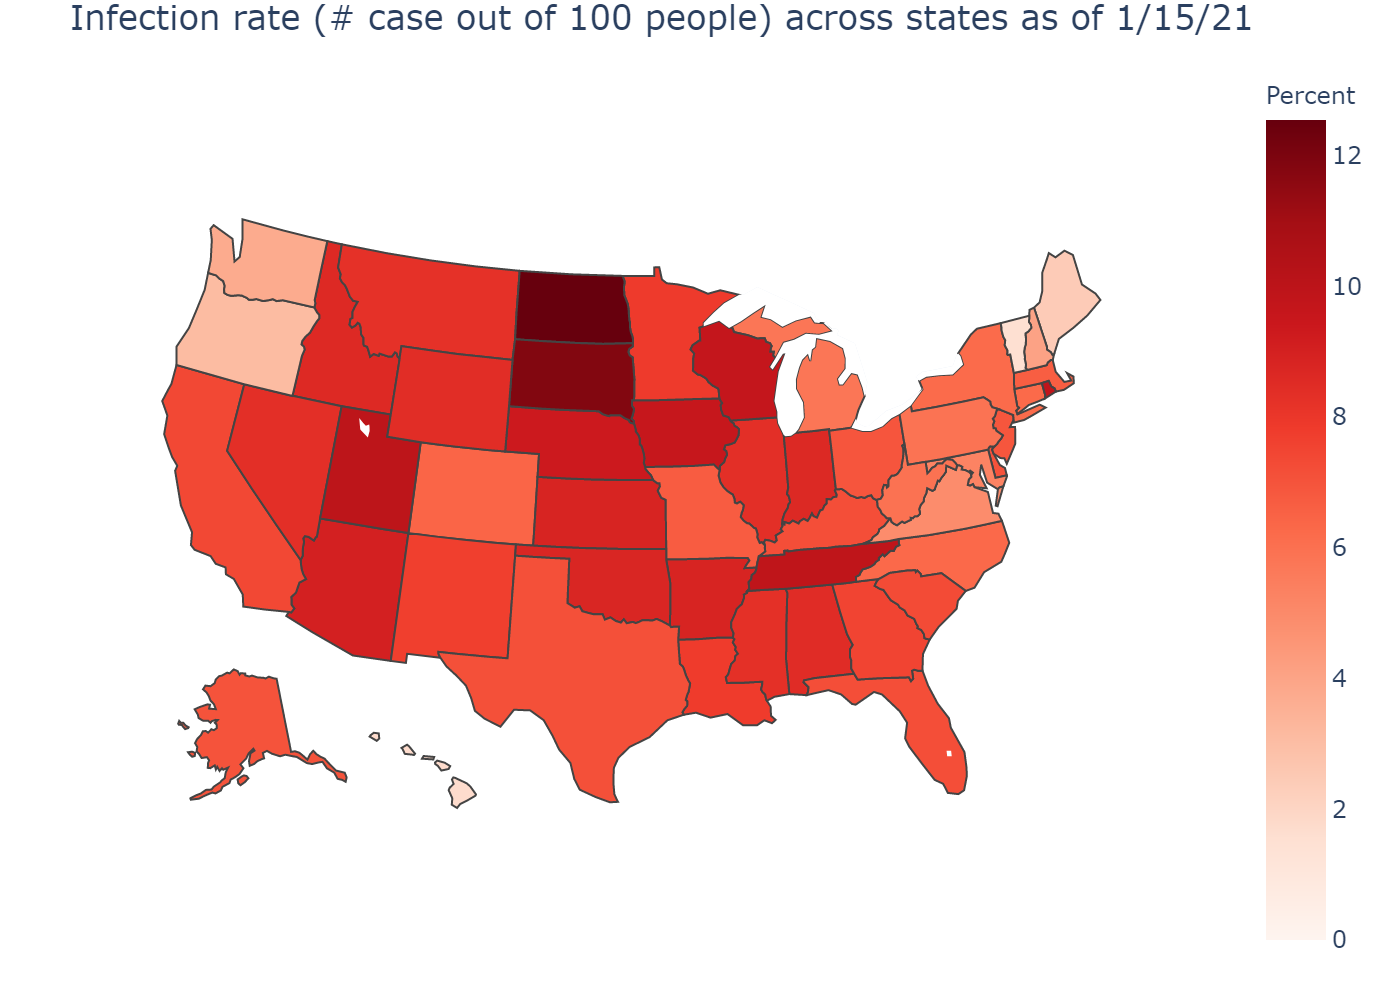

In [29]:
# Infection rate
fig = go.Figure(data=go.Choropleth(
    locations=US_state["Code"], # state names
    locationmode = "USA-states", # set the mode to country name
    z = US_state['Percent_case'].astype(float), # Data to be color-coded
    colorscale = 'Reds',
    colorbar_title = "Percent",
    text=US_state["Province_State"]    
))

fig.update_layout(
    title_text = 'Infection rate (# case out of 100 people) across states as of ' + date_string[-1],
    margin=dict(l=20, r=20, t=30, b=20),
    geo_scope='usa', # limite map scope to USA
)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

# Relations bewteen states' attributes and COVID-19

## Geographical location

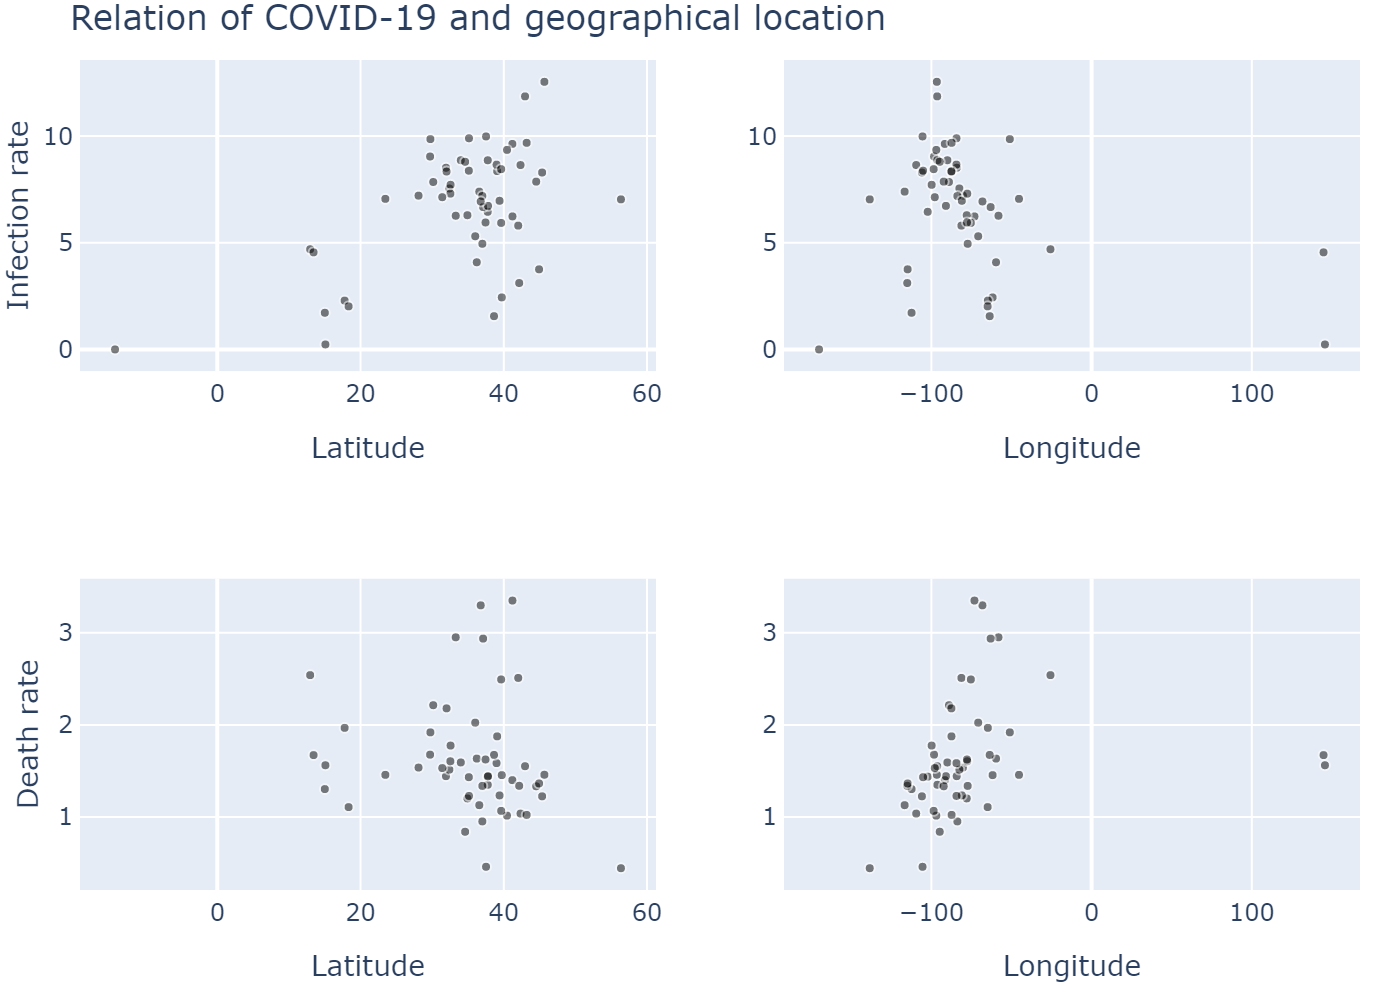

In [30]:
# Plot infection and death rate against latitute/longitude
matrix_to_plot = US_state[['Lat', 'Long_', 'Percent_case', 'Death_rate']].to_numpy()

# Plot the number of cases
fig = plotly.subplots.make_subplots(rows=2, cols=2, subplot_titles=(), shared_yaxes=False)

fig.add_trace(go.Scatter(x=matrix_to_plot[:, 0], y=matrix_to_plot[:, 2], mode='markers', 
              marker=dict(color='Black', size=5, opacity=0.5, line=dict(color='White', width=1))),
              row=1, col=1)
fig.add_trace(go.Scatter(x=matrix_to_plot[:, 1], y=matrix_to_plot[:, 2], mode='markers',
              marker=dict(color='Black', size=5, opacity=0.5, line=dict(color='White', width=1))),
              row=1, col=2)              
fig.add_trace(go.Scatter(x=matrix_to_plot[:, 0], y=matrix_to_plot[:, 3], mode='markers', 
              marker=dict(color='Black', size=5, opacity=0.5, line=dict(color='White', width=1))),
              row=2, col=1)
fig.add_trace(go.Scatter(x=matrix_to_plot[:, 1], y=matrix_to_plot[:, 3], mode='markers',
              marker=dict(color='Black', size=5, opacity=0.5, line=dict(color='White', width=1))),
              row=2, col=2)   

fig.update_xaxes(title_text="Latitude", row=1, col=1)
fig.update_xaxes(title_text="Longitude", row=1, col=2)
fig.update_xaxes(title_text="Latitude", row=2, col=1)
fig.update_xaxes(title_text="Longitude", row=2, col=2)
fig.update_yaxes(title_text="Infection rate", title_standoff = 0, row=1, col=1)
fig.update_yaxes(title_text="Death rate", title_standoff = 0, row=2, col=1)
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), height=500, showlegend=False,
                 title_text="Relation of COVID-19 and geographical location")

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

### It seems like there's not much relationship between COVID-19 and geographical location. There's only some weak trends indicating higher infection and death rate for those states on the east (see longitude)

## GDP, personal income and population density

In [31]:
# Import data
# Load data
print('Beginning data loading ...')

# Data directory
dir_data = os.path.join(os.getcwd(), 'data')

# US GDP by state 
dir_US_GDP = os.path.join(dir_data, 'US_GDP_by_state.csv')
US_GDP_state = pd.read_csv(dir_US_GDP)

# US personal income by state
dir_US_income = os.path.join(dir_data, 'US_personal_income_by_state.csv')
US_income_state = pd.read_csv(dir_US_income)

print('Data loading finished!')

Beginning data loading ...
Data loading finished!


In [32]:
# Clean income data (strip space in State column and convert string with comma to float)
US_income_state['State'] = US_income_state['State'].str.strip()
US_income_state['Personal_income'] = US_income_state['Personal_income'].str.replace(',', '').astype(float)

In [33]:
# Merge GDP table into US_state table
GDP_to_merge = US_GDP_state[US_GDP_state['Description'] == 'Current-dollar GDP (millions of current dollars)'][['GeoName', '2019']]
GDP_to_merge['2019'] = 1000000 * GDP_to_merge['2019'].astype('float')
US_state = US_state.merge(GDP_to_merge, left_on='Province_State', right_on='GeoName', how='inner')
US_state.drop(columns=['GeoName'], inplace=True)
US_state.rename(columns={'2019': 'GDP'}, inplace=True)

# Make new column of GDP per capita
US_state['GDP_per_capita'] = US_state['GDP'] / US_state['Population']

# Merge income table into US_state table
US_state = US_state.merge(US_income_state, left_on='Province_State', right_on='State', how='inner')
US_state.drop(columns=['State'], inplace=True)


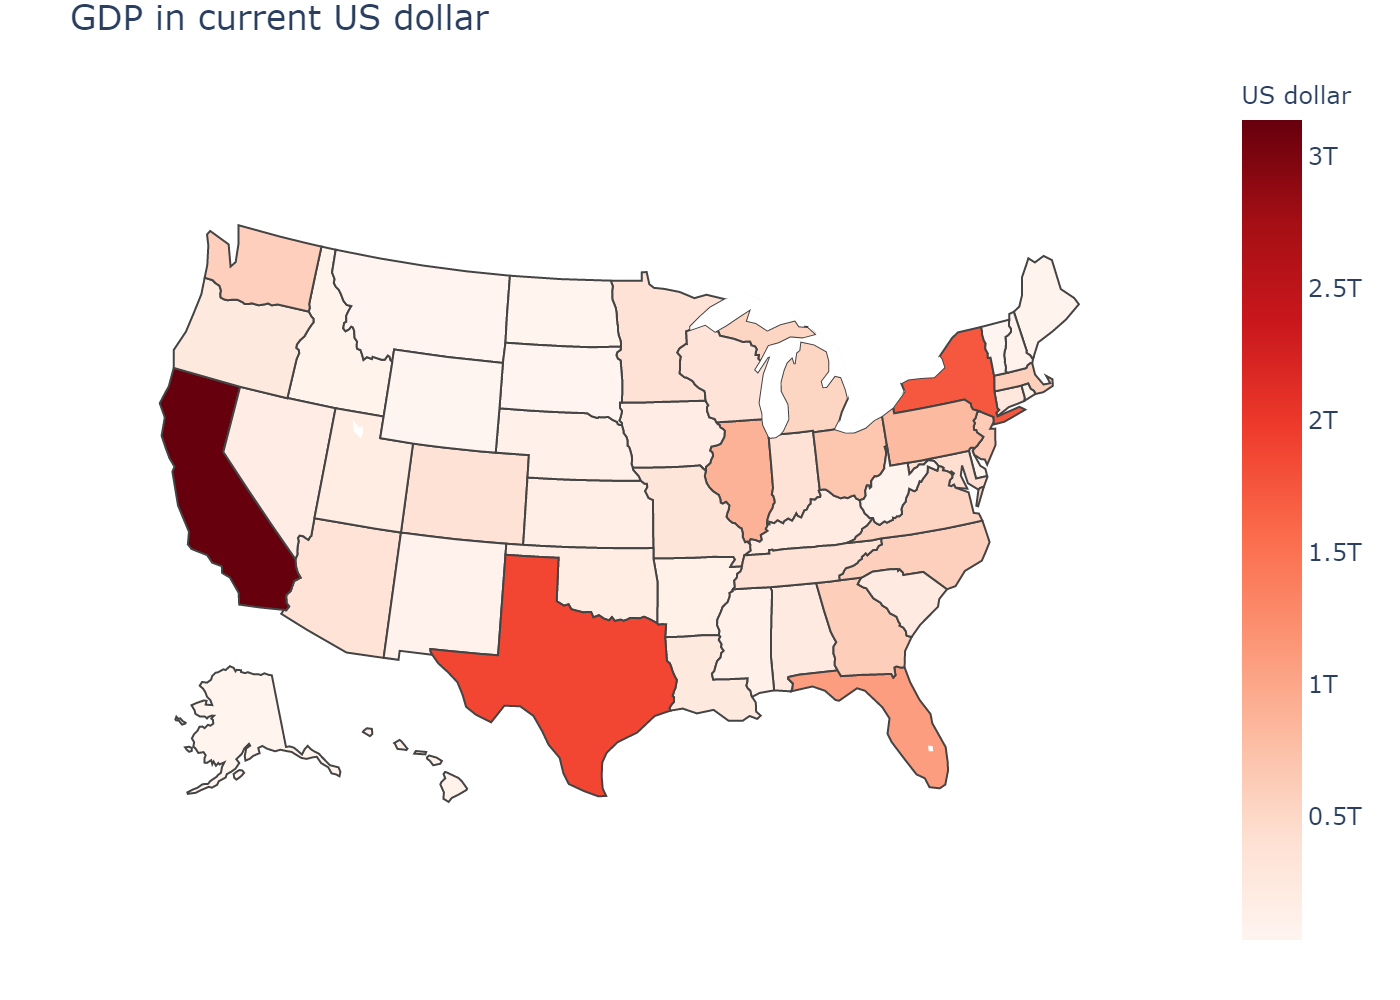

In [34]:
# Check GDP
fig = go.Figure(data=go.Choropleth(
    locations=US_state["Code"], # state names
    locationmode = "USA-states", # set the mode to country name
    z = US_state['GDP'], # Data to be color-coded
    colorscale = 'Reds',
    colorbar_title = "US dollar",
    text=US_state["Province_State"]    
))

fig.update_layout(
    title_text = 'GDP in current US dollar',
    margin=dict(l=20, r=20, t=30, b=20),
    geo_scope='usa', # limite map scope to USA
)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

In [35]:
US_state.head(10)

Code        Province_State        Lat       Long_  Population    Death  \
0   AL               Alabama  31.931113  -84.196785   4903185.0   6030.0   
1   AK                Alaska  56.360573 -138.486138    731545.0    229.0   
2   AZ               Arizona  29.714033  -98.349911   7278717.0  11040.0   
3   AR              Arkansas  34.005087  -90.033096   3017804.0   4263.0   
4   CA            California  36.582496 -116.704308  39512223.0  33002.0   
5   CO              Colorado  37.755612 -102.289687   5758736.0   5343.0   
6   CT           Connecticut  33.290944  -58.125464   3565287.0   6594.0   
7   DE              Delaware  23.465566  -45.319942    973764.0   1002.0   
8   DC  District of Columbia  12.968059  -25.672187    705749.0    842.0   
9   FL               Florida  28.101892  -80.303621  21477737.0  23799.0   

    Num_case  Percent_case  Death_rate           GDP  GDP_per_capita  \
0   417528.0      8.515445    1.444215  2.309682e+11    47105.748610   
1    51466.0      7.035247    0.444954  5.540610e+10    75738.471318   
2   658186.0      9.042610    1.677337  3.661899e+11    50309.676829   
3   267635.0      8.868535    1.592841  1.331809e+11    44131.726249   
4  2922690.0      7.396926    1.129165  3.137469e+12    79405.023605   
5   371458.0      6.450339    1.438386  3.902839e+11    67772.493825   
6   223422.0      6.266592    2.951366  2.856404e+11    80117.084543   
7    68727.0      7.057870    1.457942  7.541550e+10    77447.410255   
8    33140.0      4.695720    2.540736  1.461943e+11   207147.725324   
9  1548067.0      7.207775    1.537337  1.093351e+12    50906.233743   

   Personal_income  
0          43880.0  
1          62102.0  
2          46233.0  
3          44845.0  
4          66661.0  
5          61348.0  
6          79087.0  
7          54264.0  
8          84538.0  
9          51989.0

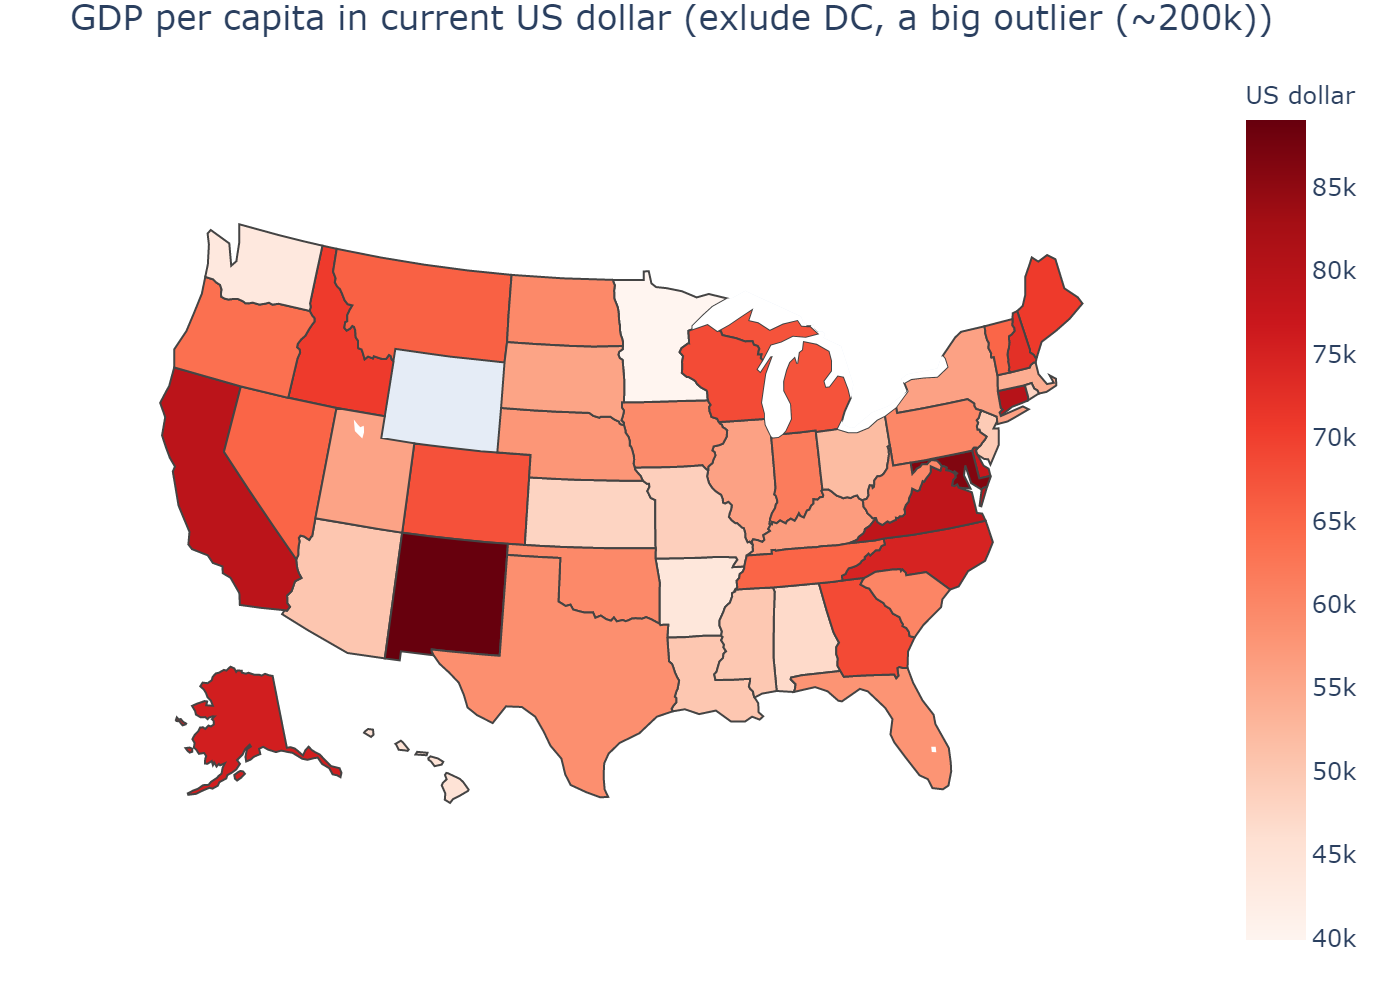

In [36]:
# Check GDP per capita
US_state_dropDC = US_state[US_state.Province_State != 'District of Columbia']
fig = go.Figure(data=go.Choropleth(
    locations=US_state["Code"], # state names
    locationmode = "USA-states", # set the mode to country name
    z = US_state_dropDC['GDP_per_capita'], # Data to be color-coded
    colorscale = 'Reds',
    colorbar_title = "US dollar",
    text=US_state["Province_State"]    
))

fig.update_layout(
    title_text = 'GDP per capita in current US dollar (exlude DC, a big outlier (~200k))',
    margin=dict(l=20, r=20, t=30, b=20),
    geo_scope='usa', # limite map scope to USA
)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

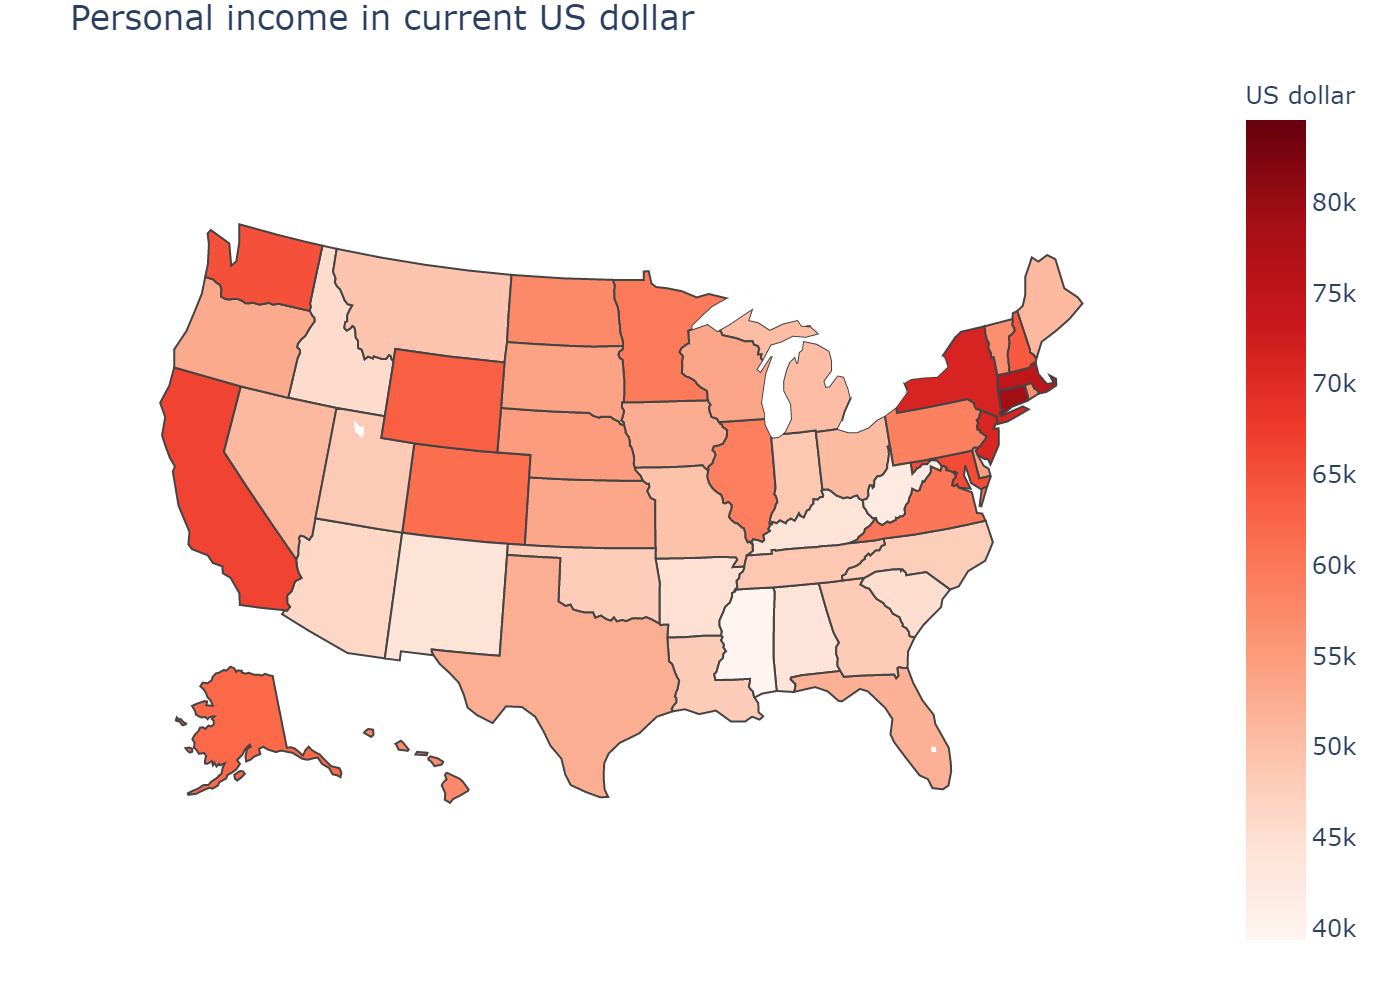

In [37]:
# Check income
fig = go.Figure(data=go.Choropleth(
    locations=US_state["Code"], # state names
    locationmode = "USA-states", # set the mode to country name
    z = US_state['Personal_income'].astype(float), # Data to be color-coded
    colorscale = 'Reds',
    colorbar_title = "US dollar",
    text=US_state["Province_State"]    
))

fig.update_layout(
    title_text = 'Personal income in current US dollar',
    margin=dict(l=20, r=20, t=30, b=20),
    geo_scope='usa', # limite map scope to USA
)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

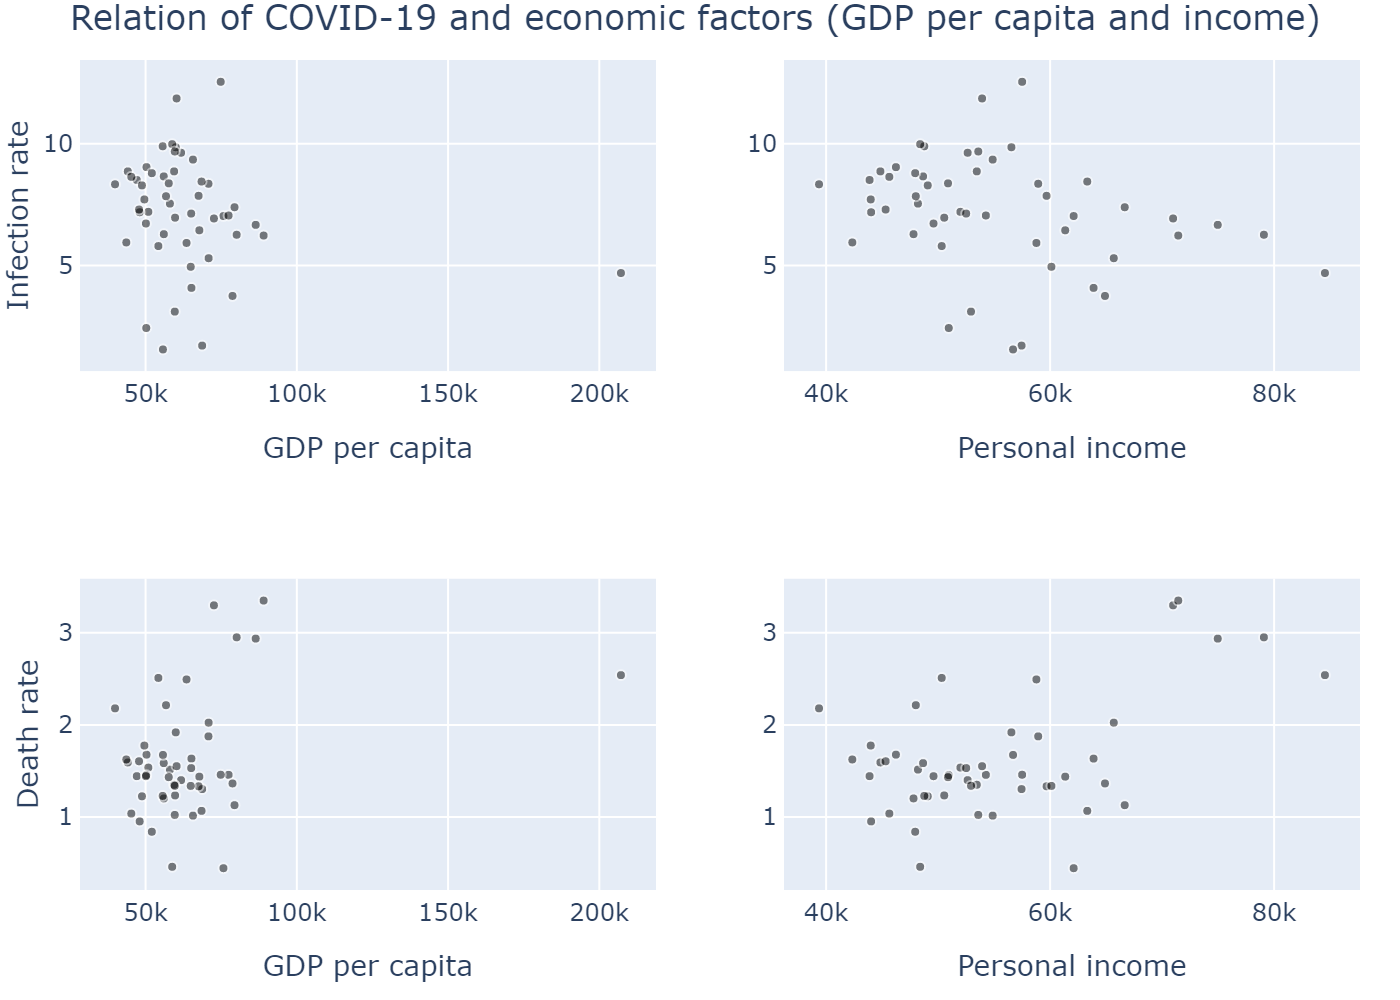

In [38]:
# Plot infection and death rate against GDP and personal income
matrix_to_plot = US_state[['GDP_per_capita', 'Personal_income', 'Percent_case', 'Death_rate']].to_numpy()

# Plot the number of cases
fig = plotly.subplots.make_subplots(rows=2, cols=2, subplot_titles=(), shared_yaxes=False)

fig.add_trace(go.Scatter(x=matrix_to_plot[:, 0], y=matrix_to_plot[:, 2], mode='markers', 
              marker=dict(color='Black', size=5, opacity=0.5, line=dict(color='White', width=1))),
              row=1, col=1)
fig.add_trace(go.Scatter(x=matrix_to_plot[:, 1], y=matrix_to_plot[:, 2], mode='markers',
              marker=dict(color='Black', size=5, opacity=0.5, line=dict(color='White', width=1))),
              row=1, col=2)              
fig.add_trace(go.Scatter(x=matrix_to_plot[:, 0], y=matrix_to_plot[:, 3], mode='markers', 
              marker=dict(color='Black', size=5, opacity=0.5, line=dict(color='White', width=1))),
              row=2, col=1)
fig.add_trace(go.Scatter(x=matrix_to_plot[:, 1], y=matrix_to_plot[:, 3], mode='markers',
              marker=dict(color='Black', size=5, opacity=0.5, line=dict(color='White', width=1))),
              row=2, col=2)   

fig.update_xaxes(title_text="GDP per capita", row=1, col=1)
fig.update_xaxes(title_text="Personal income", row=1, col=2)
fig.update_xaxes(title_text="GDP per capita", row=2, col=1)
fig.update_xaxes(title_text="Personal income", row=2, col=2)
fig.update_yaxes(title_text="Infection rate", title_standoff = 0, row=1, col=1)
fig.update_yaxes(title_text="Death rate", title_standoff = 0, row=2, col=1)
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), height=500, showlegend=False,
                 title_text="Relation of COVID-19 and economic factors (GDP per capita and income)")

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))